In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
video = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'

In [ ]:
# Установка ffmpeg (если не установлена)
!apt update
!apt install ffmpeg

# Путь к видео
video_path = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'

# Получение информации о видео
!ffmpeg -i "$video_path"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,788 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,239 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/u

In [ ]:
import cv2

# Путь к видео
video_path = '/content/drive/MyDrive/Karate_2/old_video/output_correct.mp4'

# Открытие видео
cap = cv2.VideoCapture(video_path)

# Получение информации о видео
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps if fps > 0 else 0

# Вывод информации
print(f"Ширина: {width}")
print(f"Высота: {height}")
print(f"Частота кадров (FPS): {fps}")
print(f"Количество кадров: {frame_count}")
print(f"Продолжительность: {duration:.2f} секунд")

# Закрытие видеопотока
cap.release()

Ширина: 640
Высота: 480
Частота кадров (FPS): 30.0
Количество кадров: 1568
Продолжительность: 52.27 секунд


In [ ]:
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/old_video/output_correct.mp4'

In [ ]:
import numpy as np

In [ ]:
frames_3d = np.load('/content/drive/MyDrive/Karate_2/old_video/frames_3d.npy')

In [ ]:
frames_3d.shape

(1679, 33, 3)

In [ ]:
print(frames_3d.shape)  # Должно быть (количество_кадров, количество_точек, оси_XYZ)
print(frames_3d[:1])    # Проверьте первые несколько строк

(1679, 33, 3)
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


In [ ]:
# Удаление строк, содержащих только NaN
frames_3d = frames_3d[~np.all(np.isnan(frames_3d), axis=(1, 2))]

In [ ]:
# Установка необходимых библиотек
!pip install numpy pandas scipy matplotlib filterpy

# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from filterpy.kalman import KalmanFilter, rts_smoother
from filterpy.common import Q_discrete_white_noise
import math  # Для использования factorial

# Параметры фильтрации
config_dict = {
    'filtering': {
        'type': 'kalman',  # Тип фильтра: kalman, butterworth, gaussian, LOESS, median
        'kalman': {
            'trust_ratio': 10,
            'smooth': True
        },
        'butterworth': {
            'order': 4,
            'cut_off_frequency': 6
        },
        'gaussian': {
            'sigma_kernel': 2
        },
        'LOESS': {
            'nb_values_used': 0.1
        },
        'median': {
            'kernel_size': 5
        }
    },
    'display_figures': True,  # Отображать графики
    'frame_rate': 30  # Частота кадров
}

# Функция Kalman Filter
def kalman_filter(coords, frame_rate, measurement_noise, process_noise, nb_dimensions=3, nb_derivatives=3, smooth=True):
    # Variables
    dim_x = nb_dimensions * nb_derivatives  # 9 state variables
    dt = 1 / frame_rate
    # Filter definition
    f = KalmanFilter(dim_x=dim_x, dim_z=nb_dimensions)
    # States: initial position, velocity, accel, in 3D
    def derivate_array(arr, dt=1):
        return np.diff(arr, axis=0) / dt

    def repeat(func, arg_func, nb_reps):
        for i in range(nb_reps):
            arg_func = func(arg_func)
        return arg_func

    x_init = []
    for n_der in range(nb_derivatives):
        x_init += [repeat(derivate_array, coords, n_der)[0]]  # pose*3D, vel*3D, accel*3D
    f.x = np.array(x_init).reshape(nb_dimensions, nb_derivatives).T.flatten()  # pose, vel, accel *3D
    # State transition matrix
    F_per_coord = np.zeros((int(dim_x / nb_dimensions), int(dim_x / nb_dimensions)))
    for i in range(nb_derivatives):
        for j in range(min(i + 1, nb_derivatives)):
            F_per_coord[j, i] = dt**(i - j) / math.factorial(i - j)
    f.F = np.kron(np.eye(nb_dimensions), F_per_coord)
    # No control input
    f.B = None
    # Measurement matrix (only positions)
    H = np.zeros((nb_dimensions, dim_x))
    for i in range(min(nb_dimensions, dim_x)):
        H[i, int(i * (dim_x / nb_dimensions))] = 1
    f.H = H
    # Covariance matrix
    f.P *= measurement_noise
    # Measurement noise
    f.R = np.diag([measurement_noise**2] * nb_dimensions)
    # Process noise
    f.Q = Q_discrete_white_noise(nb_derivatives, dt=dt, var=process_noise**2, block_size=nb_dimensions)
    # Run filter: predict and update for each frame
    mu, cov, _, _ = f.batch_filter(coords)  # equivalent to below
    ind_of_position = [int(d * (dim_x / nb_dimensions)) for d in range(nb_dimensions)]
    coords_filt = np.array(mu)[:, ind_of_position]
    # RTS smoother
    if smooth:
        mu2, P, C, _ = f.rts_smoother(mu, cov)
        coords_filt = np.array(mu2)[:, ind_of_position]
    return coords_filt

# Функция для фильтрации одномерного сигнала
def filter1d(col, config_dict, filter_type, frame_rate):
    filter_mapping = {
        'kalman': kalman_filter_1d,
        'butterworth': butterworth_filter_1d,
        'gaussian': gaussian_filter_1d,
        'LOESS': loess_filter_1d,
        'median': median_filter_1d
    }
    filter_fun = filter_mapping[filter_type]
    return filter_fun(config_dict, frame_rate, col)

# Функции фильтрации (остаются без изменений)
def kalman_filter_1d(config_dict, frame_rate, col):
    trustratio = int(config_dict.get('filtering').get('kalman').get('trust_ratio'))
    smooth = int(config_dict.get('filtering').get('kalman').get('smooth'))
    measurement_noise = 20
    process_noise = measurement_noise * trustratio
    # split into sequences of not nans
    col_filtered = col.copy()
    mask = np.isnan(col_filtered) | (col_filtered == 0)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = kalman_filter(
                col_filtered[seq_f], frame_rate, measurement_noise, process_noise, nb_dimensions=1, nb_derivatives=3, smooth=smooth
            ).flatten()
    return col_filtered

def butterworth_filter_1d(config_dict, frame_rate, col):
    order = int(config_dict.get('filtering').get('butterworth').get('order'))
    cutoff = int(config_dict.get('filtering').get('butterworth').get('cut_off_frequency'))
    b, a = signal.butter(order / 2, cutoff / (frame_rate / 2), 'low', analog=False)
    padlen = 3 * max(len(a), len(b))
    col_filtered = col.copy()
    mask = np.isnan(col_filtered) | (col_filtered == 0)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences if len(seq) > padlen]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = signal.filtfilt(b, a, col_filtered[seq_f])
    return col_filtered

def gaussian_filter_1d(config_dict, frame_rate, col):
    sigma_kernel = int(config_dict.get('filtering').get('gaussian').get('sigma_kernel'))
    return gaussian_filter1d(col, sigma_kernel)

def loess_filter_1d(config_dict, frame_rate, col):
    kernel = config_dict.get('filtering').get('LOESS').get('nb_values_used')
    col_filtered = col.copy()
    mask = np.isnan(col_filtered)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences if len(seq) > kernel]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = lowess(col_filtered[seq_f], seq_f, is_sorted=True, frac=kernel / len(seq_f), it=0)[:, 1]
    return col_filtered

def median_filter_1d(config_dict, frame_rate, col):
    kernel_size = config_dict.get('filtering').get('median').get('kernel_size')
    return signal.medfilt(col, kernel_size=kernel_size)

# Основная функция фильтрации
def filter_all(frames_3d, config_dict):
    frame_rate = config_dict.get('frame_rate')
    display_figures = config_dict.get('filtering').get('display_figures')
    filter_type = config_dict.get('filtering').get('type')

    # Преобразование frames_3d в DataFrame
    n_frames, n_points, _ = frames_3d.shape
    columns = [f'Point_{i}_{axis}' for i in range(n_points) for axis in ['X', 'Y', 'Z']]
    df = pd.DataFrame(frames_3d.reshape(n_frames, -1), columns=columns)

    print(df)
    # Фильтрация
    df_filtered = df.apply(filter1d, axis=0, args=[config_dict, filter_type, frame_rate])

    # Визуализация
    if display_figures:
        for point_id in range(n_points):
            fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
            for ax, axis in zip(axes, ['X', 'Y', 'Z']):
                ax.plot(df[f'Point_{point_id}_{axis}'], label='Original')
                ax.plot(df_filtered[f'Point_{point_id}_{axis}'], label='Filtered')
                ax.set_ylabel(axis)
                ax.legend()
            plt.xlabel('Frame')
            plt.suptitle(f'Point {point_id}')
            plt.show()

    # Сохранение результатов
    filtered_coords = df_filtered.to_numpy().reshape(n_frames, n_points, 3)
    np.save('filtered_coords.npy', filtered_coords)
    print("Отфильтрованные координаты сохранены в 'filtered_coords.npy'")

# Запуск фильтрации
filter_all(frames_3d, config_dict)

      Point_0_X  Point_0_Y  Point_0_Z  Point_1_X  Point_1_Y  Point_1_Z  \
0      4.909519  -0.973870   1.663893   4.942895  -0.997585   1.693022   
1      4.856181  -0.914674   1.650691   4.887995  -0.939032   1.681127   
2      4.853736  -0.909991   1.650702   4.895129  -0.943931   1.684218   
3      4.794261  -0.840947   1.662678   4.823386  -0.862169   1.693682   
4      4.740984  -0.784696   1.665224   4.778278  -0.811663   1.696803   
...         ...        ...        ...        ...        ...        ...   
1573   4.838430  -0.489215   1.659664   4.873220  -0.518468   1.686179   
1574   4.872914  -0.532040   1.659701   4.902686  -0.558653   1.685078   
1575   4.904745  -0.580090   1.664647   4.936273  -0.605524   1.692909   
1576   4.947928  -0.640807   1.675793   4.979603  -0.666535   1.701812   
1577   4.994126  -0.699189   1.689040   5.033171  -0.735984   1.716574   

      Point_2_X  Point_2_Y  Point_2_Z  Point_3_X  ...  Point_29_Z  Point_30_X  \
0      4.951066  -1.003678   1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Установка необходимых библиотек
!pip install numpy pandas scipy matplotlib filterpy

# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from filterpy.kalman import KalmanFilter, rts_smoother
from filterpy.common import Q_discrete_white_noise
import math  # Для использования factorial

# Параметры фильтрации
config_dict = {
    'filtering': {
        'type': 'kalman',  # Тип фильтра: kalman, butterworth, gaussian, LOESS, median
        'kalman': {
            'trust_ratio': 10,
            'smooth': True
        },
        'butterworth': {
            'order': 4,
            'cut_off_frequency': 6
        },
        'gaussian': {
            'sigma_kernel': 2
        },
        'LOESS': {
            'nb_values_used': 0.1
        },
        'median': {
            'kernel_size': 5
        }
    },
    'display_figures': True,  # Отображать графики
    'frame_rate': 30  # Частота кадров
}

# Функция Kalman Filter
def kalman_filter(coords, frame_rate, measurement_noise, process_noise, nb_dimensions=3, nb_derivatives=3, smooth=True):
    # Variables
    dim_x = nb_dimensions * nb_derivatives  # 9 state variables
    dt = 1 / frame_rate
    # Filter definition
    f = KalmanFilter(dim_x=dim_x, dim_z=nb_dimensions)
    # States: initial position, velocity, accel, in 3D
    def derivate_array(arr, dt=1):
        return np.diff(arr, axis=0) / dt

    def repeat(func, arg_func, nb_reps):
        for i in range(nb_reps):
            arg_func = func(arg_func)
        return arg_func

    x_init = []
    for n_der in range(nb_derivatives):
        x_init += [repeat(derivate_array, coords, n_der)[0]]  # pose*3D, vel*3D, accel*3D
    f.x = np.array(x_init).reshape(nb_dimensions, nb_derivatives).T.flatten()  # pose, vel, accel *3D
    # State transition matrix
    F_per_coord = np.zeros((int(dim_x / nb_dimensions), int(dim_x / nb_dimensions)))
    for i in range(nb_derivatives):
        for j in range(min(i + 1, nb_derivatives)):
            F_per_coord[j, i] = dt**(i - j) / math.factorial(i - j)
    f.F = np.kron(np.eye(nb_dimensions), F_per_coord)
    # No control input
    f.B = None
    # Measurement matrix (only positions)
    H = np.zeros((nb_dimensions, dim_x))
    for i in range(min(nb_dimensions, dim_x)):
        H[i, int(i * (dim_x / nb_dimensions))] = 1
    f.H = H
    # Covariance matrix
    f.P *= measurement_noise
    # Measurement noise
    f.R = np.diag([measurement_noise**2] * nb_dimensions)
    # Process noise
    f.Q = Q_discrete_white_noise(nb_derivatives, dt=dt, var=process_noise**2, block_size=nb_dimensions)
    # Run filter: predict and update for each frame
    mu, cov, _, _ = f.batch_filter(coords)  # equivalent to below
    ind_of_position = [int(d * (dim_x / nb_dimensions)) for d in range(nb_dimensions)]
    coords_filt = np.array(mu)[:, ind_of_position]
    # RTS smoother
    if smooth:
        mu2, P, C, _ = f.rts_smoother(mu, cov)
        coords_filt = np.array(mu2)[:, ind_of_position]
    return coords_filt

# Функция для фильтрации одномерного сигнала
def filter1d(col, config_dict, filter_type, frame_rate):
    filter_mapping = {
        'kalman': kalman_filter_1d,
        'butterworth': butterworth_filter_1d,
        'gaussian': gaussian_filter_1d,
        'LOESS': loess_filter_1d,
        'median': median_filter_1d
    }
    filter_fun = filter_mapping[filter_type]
    return filter_fun(config_dict, frame_rate, col)

# Функции фильтрации (остаются без изменений)
def kalman_filter_1d(config_dict, frame_rate, col):
    trustratio = int(config_dict.get('filtering').get('kalman').get('trust_ratio'))
    smooth = int(config_dict.get('filtering').get('kalman').get('smooth'))
    measurement_noise = 20
    process_noise = measurement_noise * trustratio
    # split into sequences of not nans
    col_filtered = col.copy()
    mask = np.isnan(col_filtered) | (col_filtered == 0)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = kalman_filter(
                col_filtered[seq_f], frame_rate, measurement_noise, process_noise, nb_dimensions=1, nb_derivatives=3, smooth=smooth
            ).flatten()
    return col_filtered

def butterworth_filter_1d(config_dict, frame_rate, col):
    order = int(config_dict.get('filtering').get('butterworth').get('order'))
    cutoff = int(config_dict.get('filtering').get('butterworth').get('cut_off_frequency'))
    b, a = signal.butter(order / 2, cutoff / (frame_rate / 2), 'low', analog=False)
    padlen = 3 * max(len(a), len(b))
    col_filtered = col.copy()
    mask = np.isnan(col_filtered) | (col_filtered == 0)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences if len(seq) > padlen]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = signal.filtfilt(b, a, col_filtered[seq_f])
    return col_filtered

def gaussian_filter_1d(config_dict, frame_rate, col):
    sigma_kernel = int(config_dict.get('filtering').get('gaussian').get('sigma_kernel'))
    return gaussian_filter1d(col, sigma_kernel)

def loess_filter_1d(config_dict, frame_rate, col):
    kernel = config_dict.get('filtering').get('LOESS').get('nb_values_used')
    col_filtered = col.copy()
    mask = np.isnan(col_filtered)
    falsemask_indices = np.where(~mask)[0]
    gaps = np.where(np.diff(falsemask_indices) > 1)[0] + 1
    idx_sequences = np.split(falsemask_indices, gaps)
    if idx_sequences[0].size > 0:
        idx_sequences_to_filter = [seq for seq in idx_sequences if len(seq) > kernel]
        for seq_f in idx_sequences_to_filter:
            col_filtered[seq_f] = lowess(col_filtered[seq_f], seq_f, is_sorted=True, frac=kernel / len(seq_f), it=0)[:, 1]
    return col_filtered

def median_filter_1d(config_dict, frame_rate, col):
    kernel_size = config_dict.get('filtering').get('median').get('kernel_size')
    return signal.medfilt(col, kernel_size=kernel_size)

def filter_all(frames_3d, config_dict):
    frame_rate = config_dict.get('frame_rate')
    display_figures = config_dict.get('filtering').get('display_figures')
    filter_type = config_dict.get('filtering').get('type')

    # Сохраняем маску для строк без NaN
    mask = ~np.all(np.isnan(frames_3d), axis=(1, 2))

    # Преобразование frames_3d в DataFrame
    n_frames, n_points, _ = frames_3d.shape
    columns = [f'Point_{i}_{axis}' for i in range(n_points) for axis in ['X', 'Y', 'Z']]
    df = pd.DataFrame(frames_3d.reshape(n_frames, -1), columns=columns)

    # Фильтрация
    df_filtered = df.apply(filter1d, axis=0, args=[config_dict, filter_type, frame_rate])

    # Восстановление до исходной размерности
    restored_df = pd.DataFrame(np.full_like(df.to_numpy(), np.nan), columns=columns)
    restored_df.loc[mask] = df_filtered.loc[mask]

    # Визуализация
    #if display_figures:
    for point_id in range(n_points):
            fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
            for ax, axis in zip(axes, ['X', 'Y', 'Z']):
                ax.plot(df[f'Point_{point_id}_{axis}'], label='Original')
                ax.plot(restored_df[f'Point_{point_id}_{axis}'], label='Filtered')
                ax.set_ylabel(axis)
                ax.legend()
            plt.xlabel('Frame')
            plt.suptitle(f'Point {point_id}')
            plt.show()

    # Сохранение результатов
    filtered_coords = restored_df.to_numpy().reshape(n_frames, n_points, 3)
    np.save('filtered_coords.npy', filtered_coords)
    print("Отфильтрованные координаты сохранены в 'filtered_coords-old.npy'")
    return filtered_coords


Исходная форма данных: (1743, 33, 3)
Форма данных после удаления строк с NaN: (1541, 33, 3)


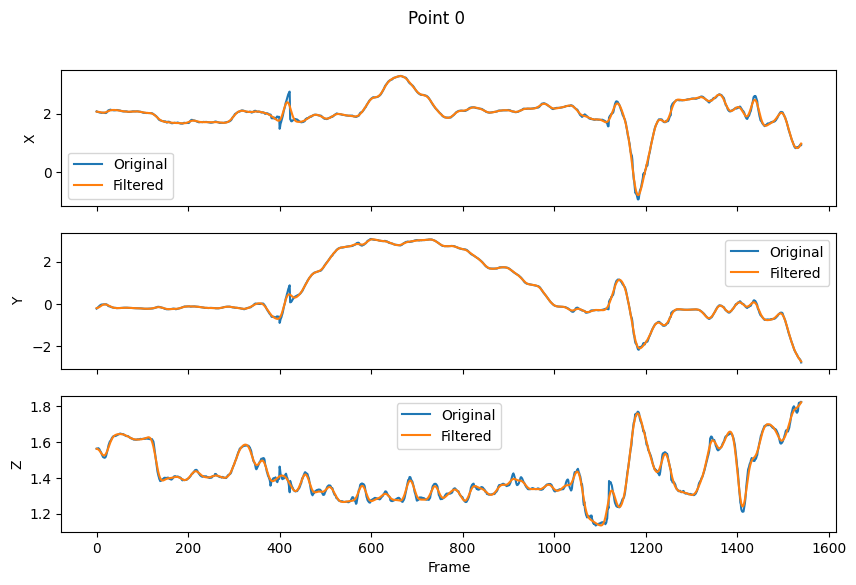

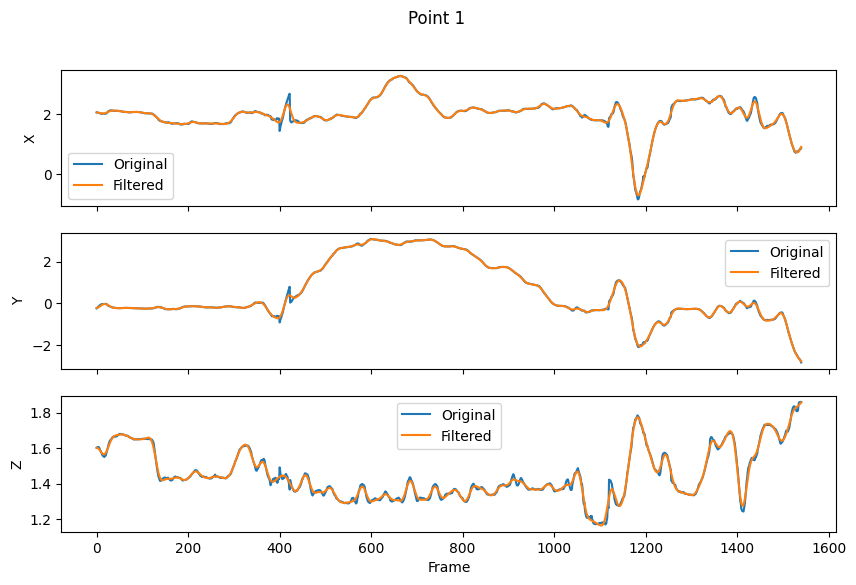

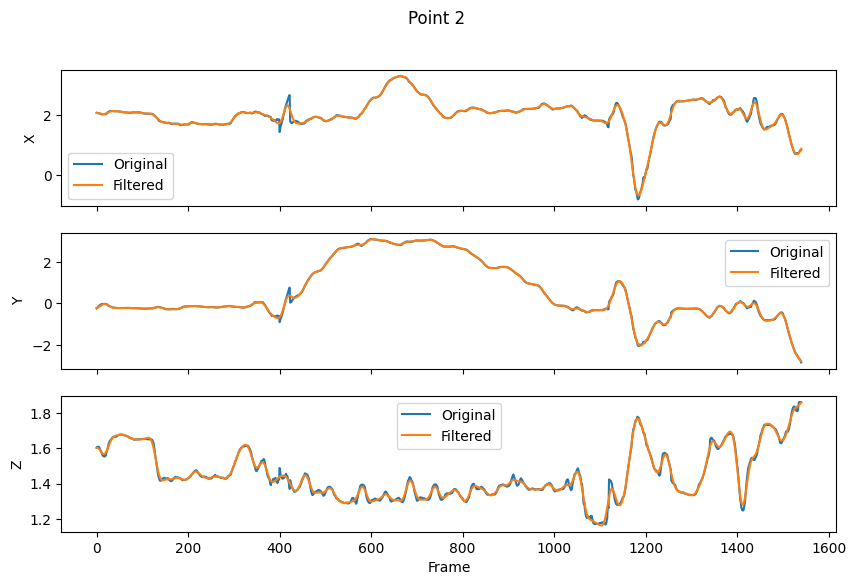

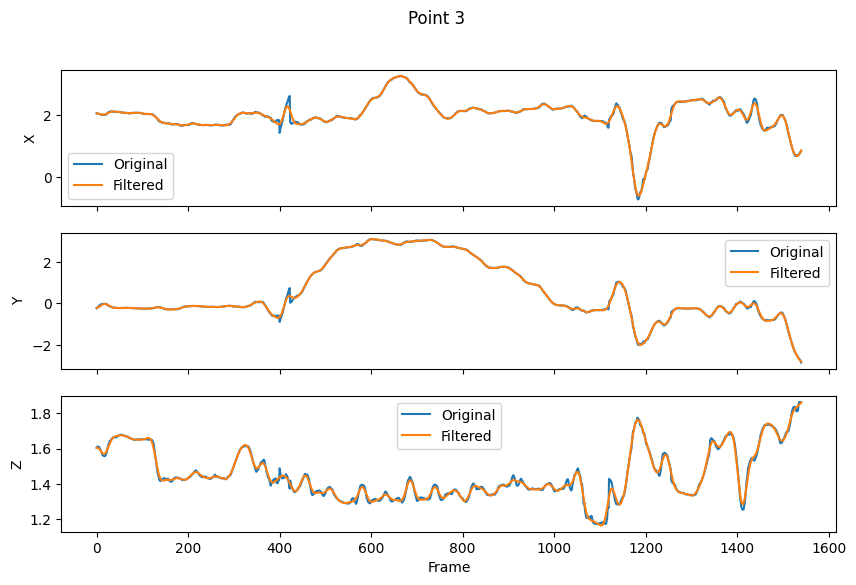

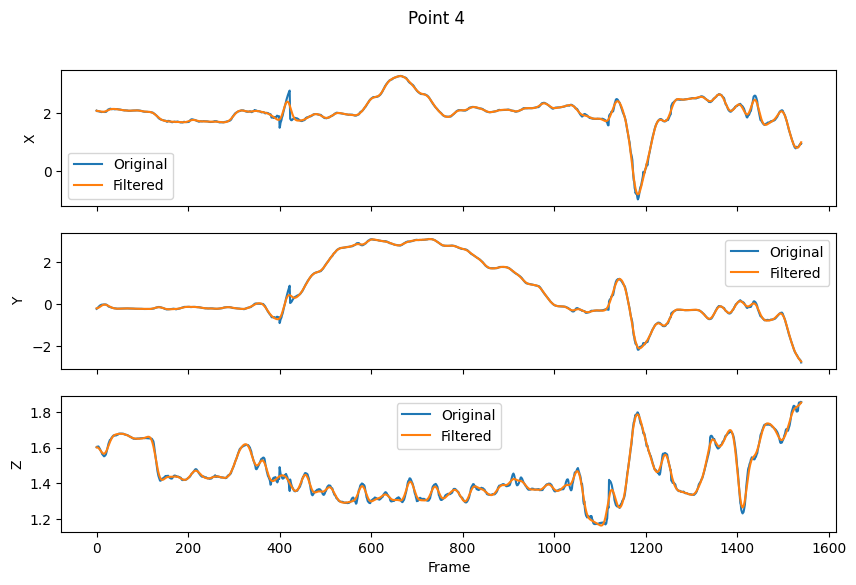

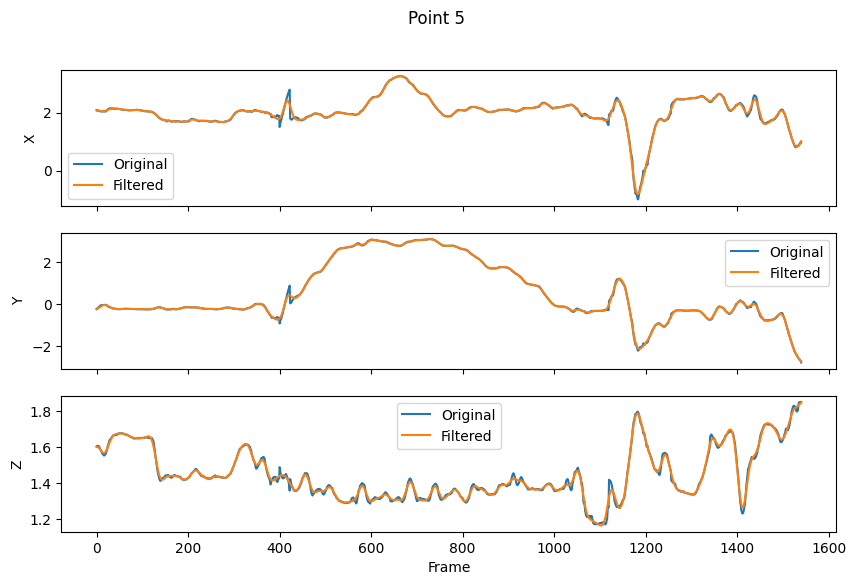

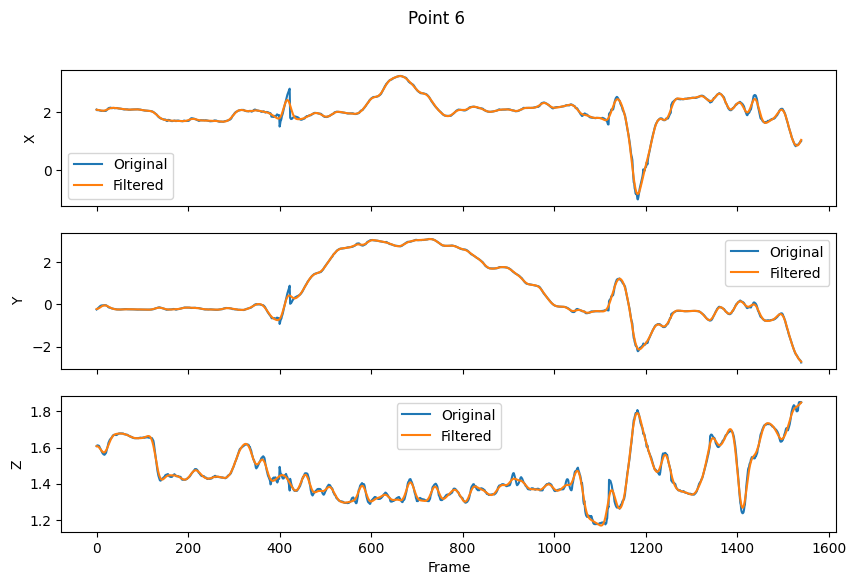

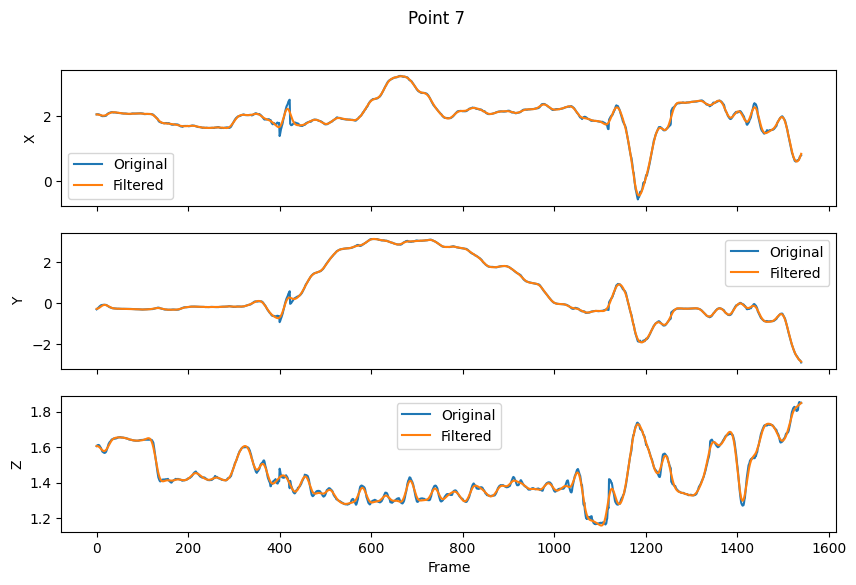

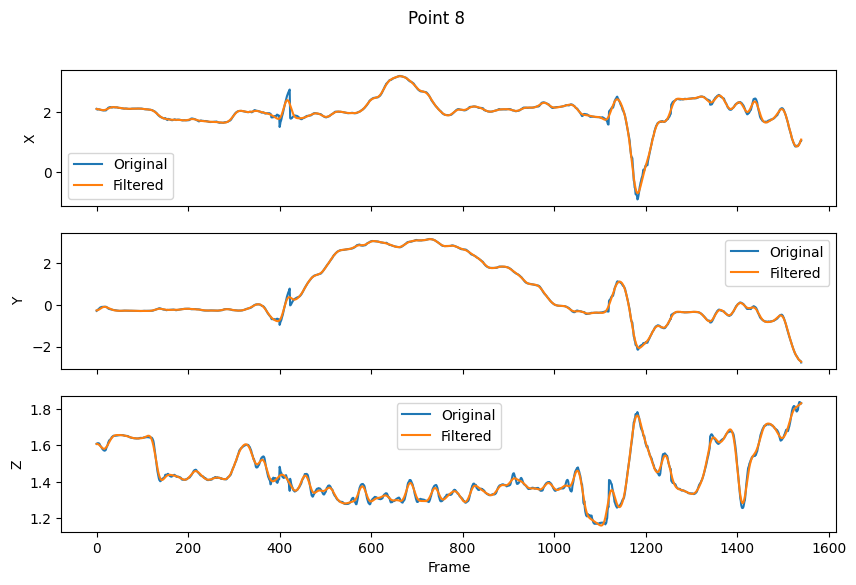

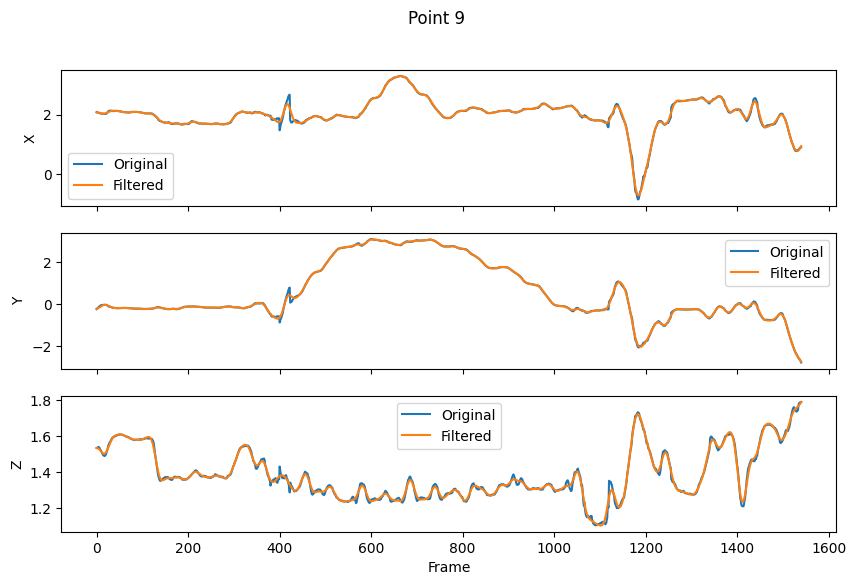

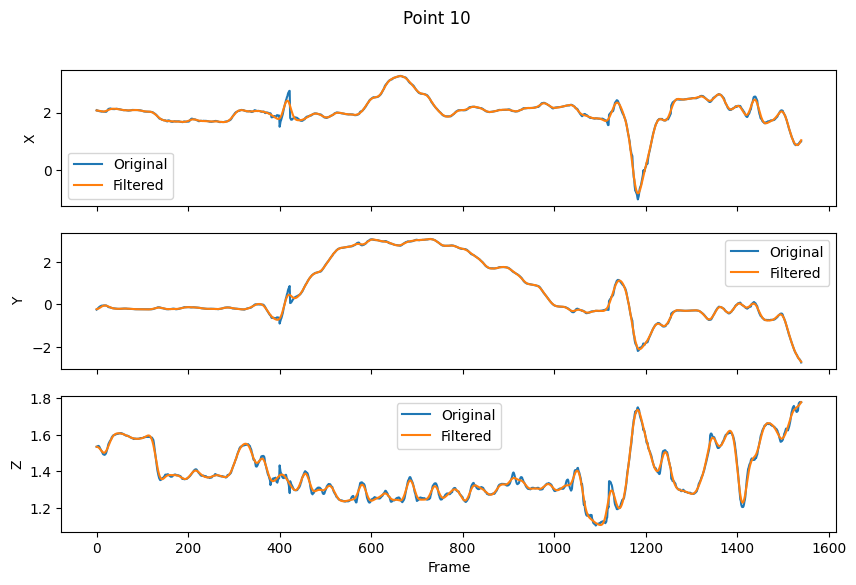

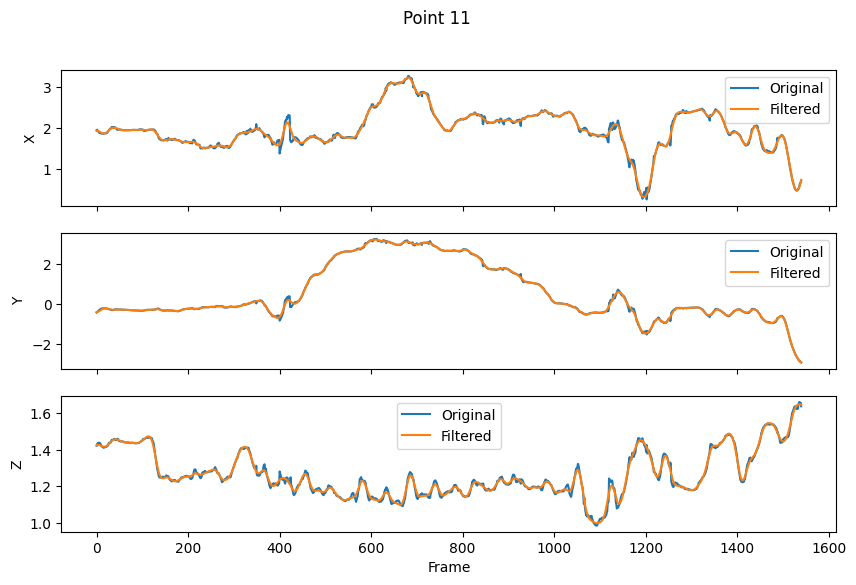

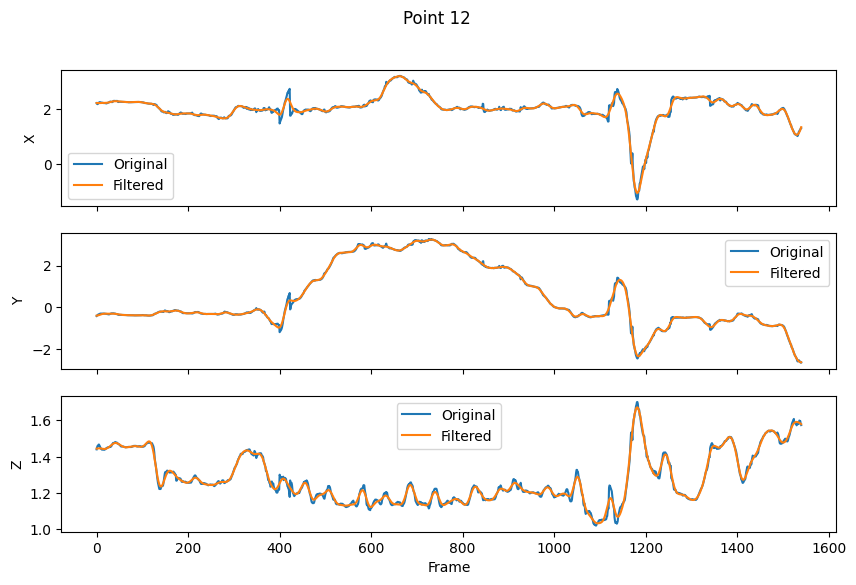

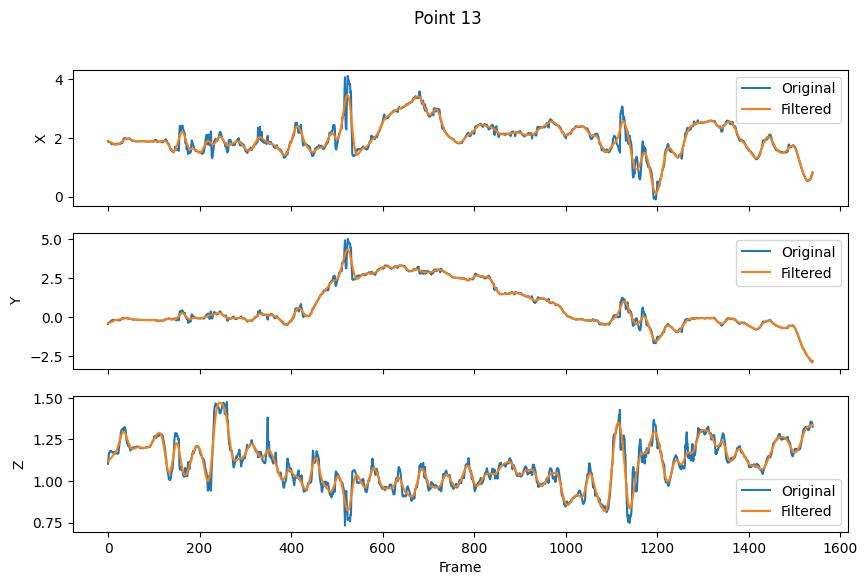

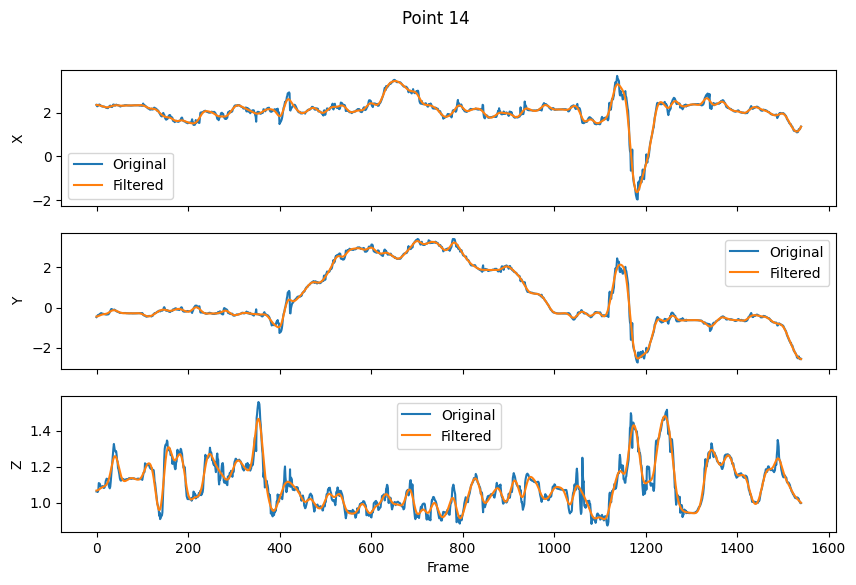

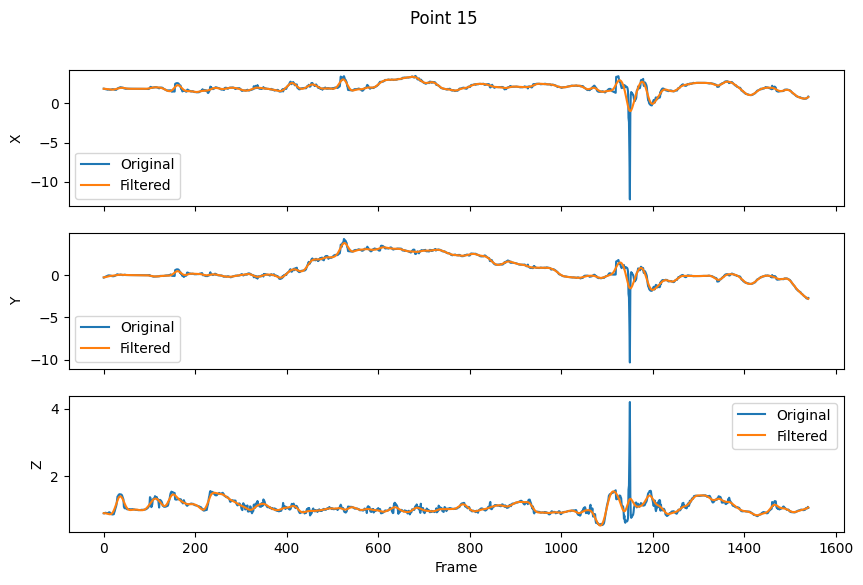

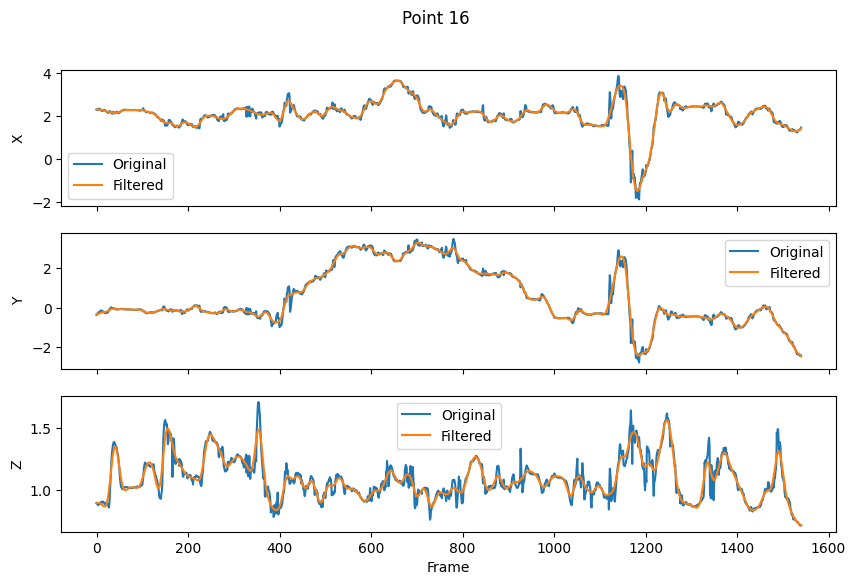

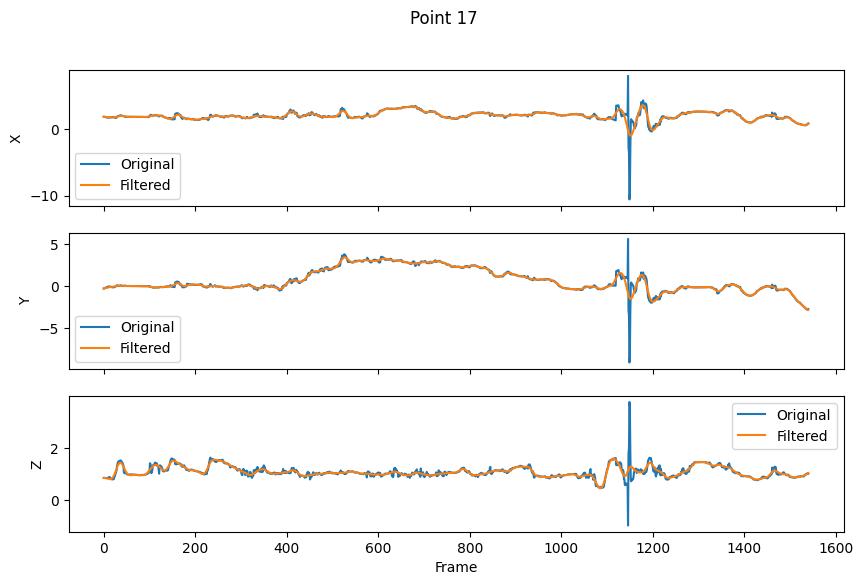

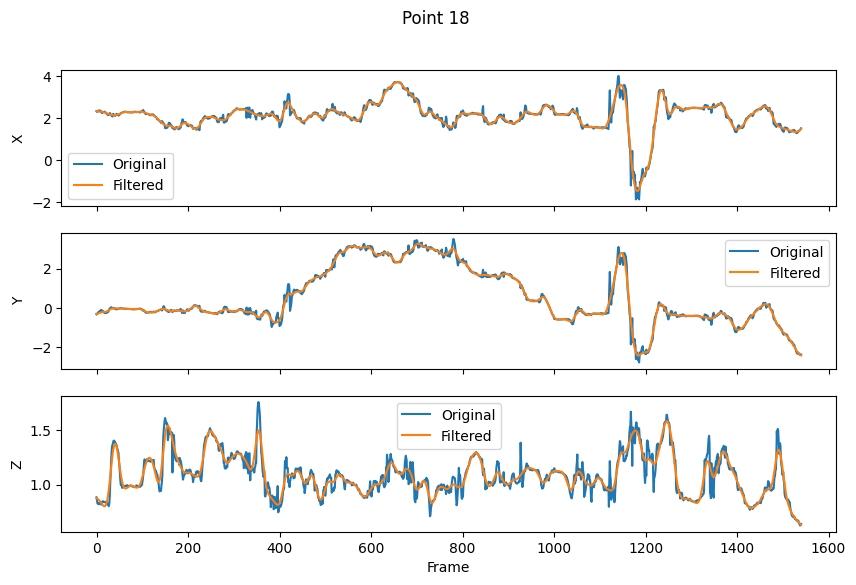

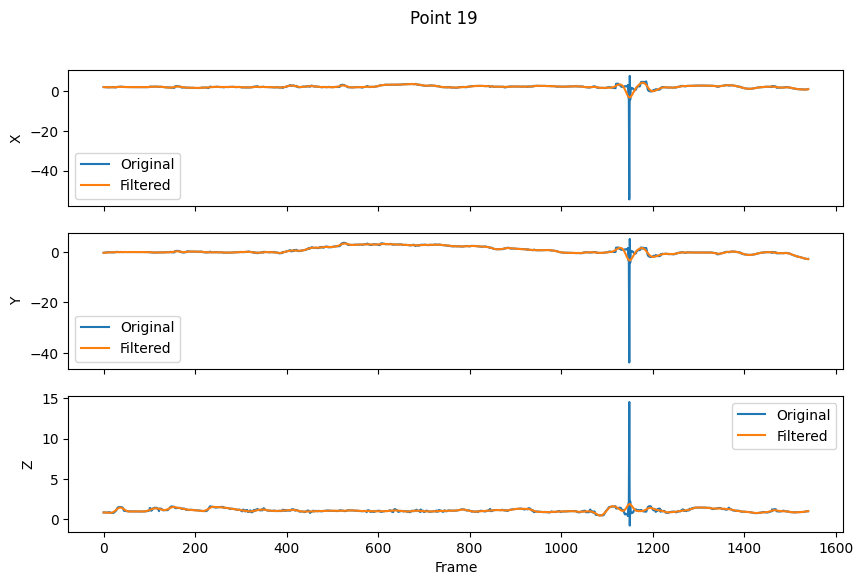

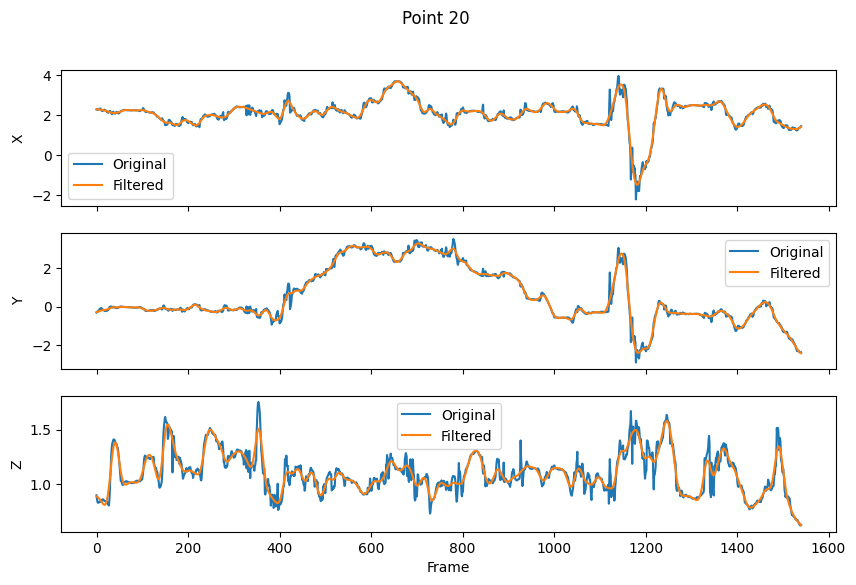

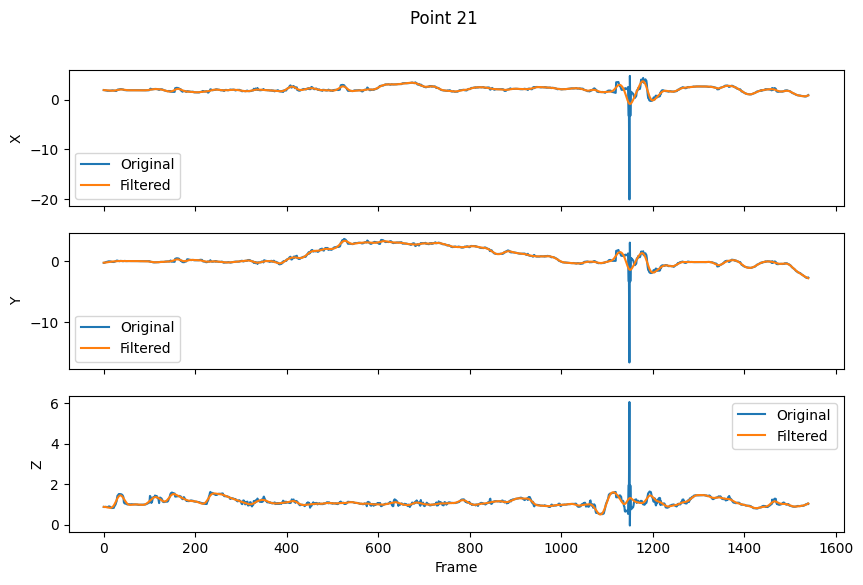

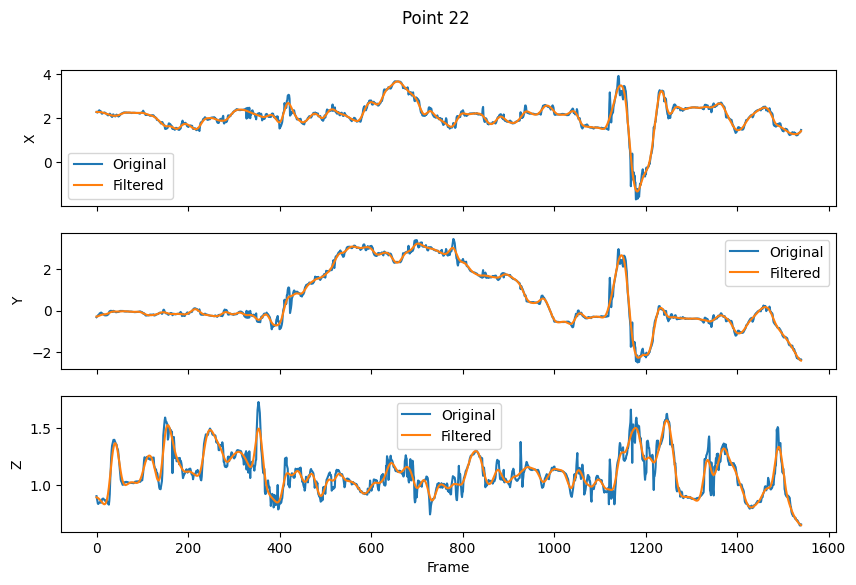

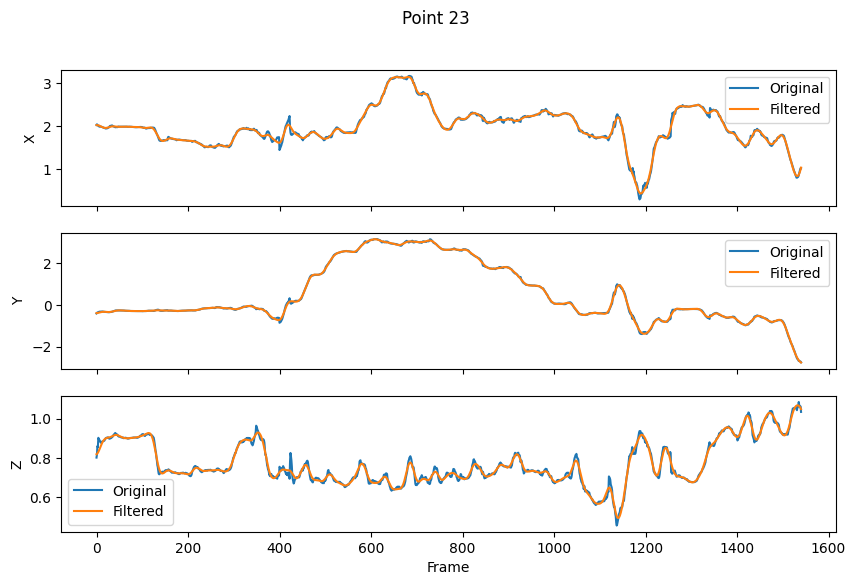

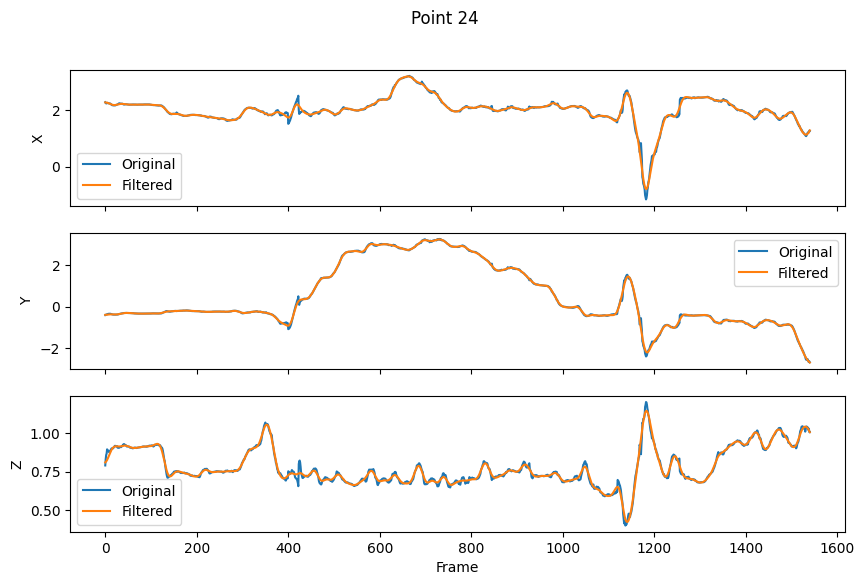

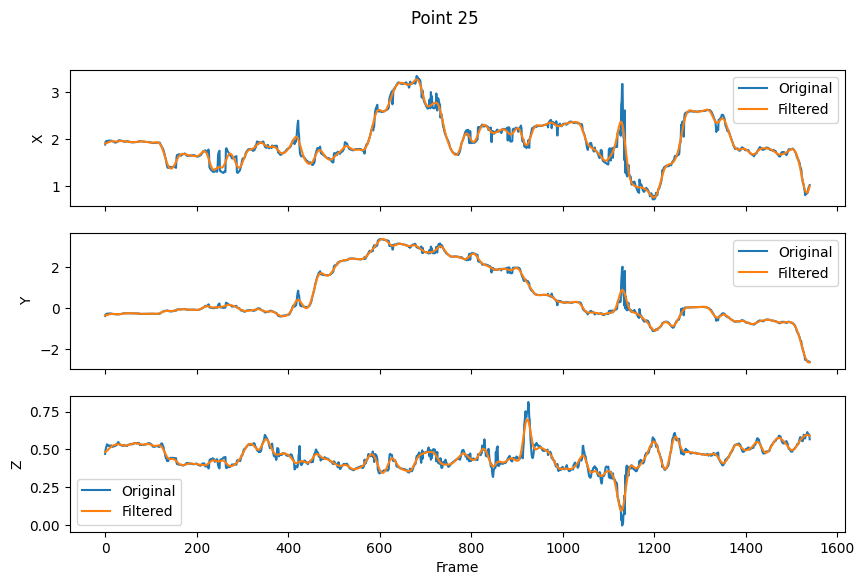

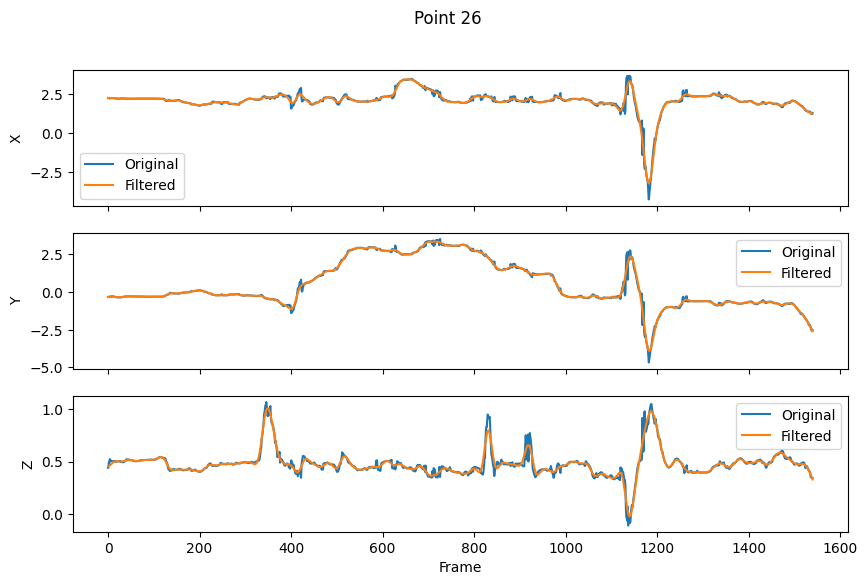

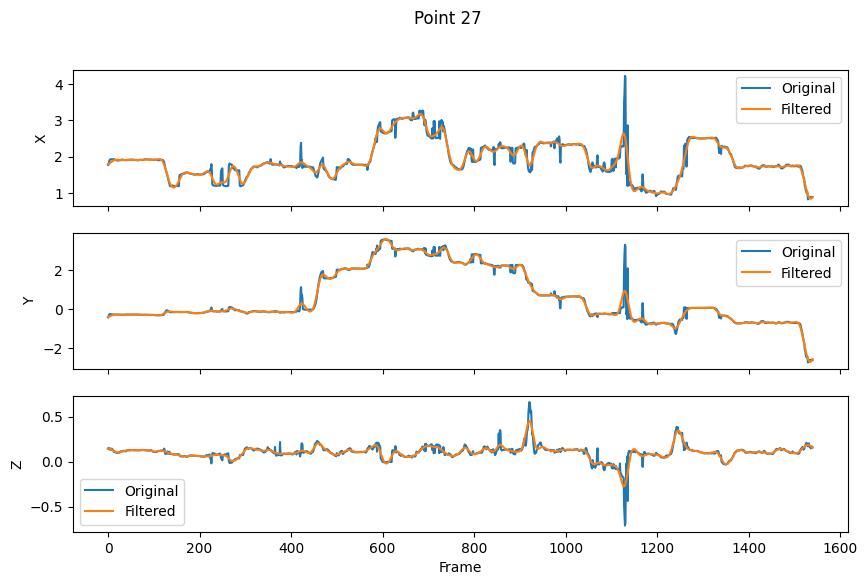

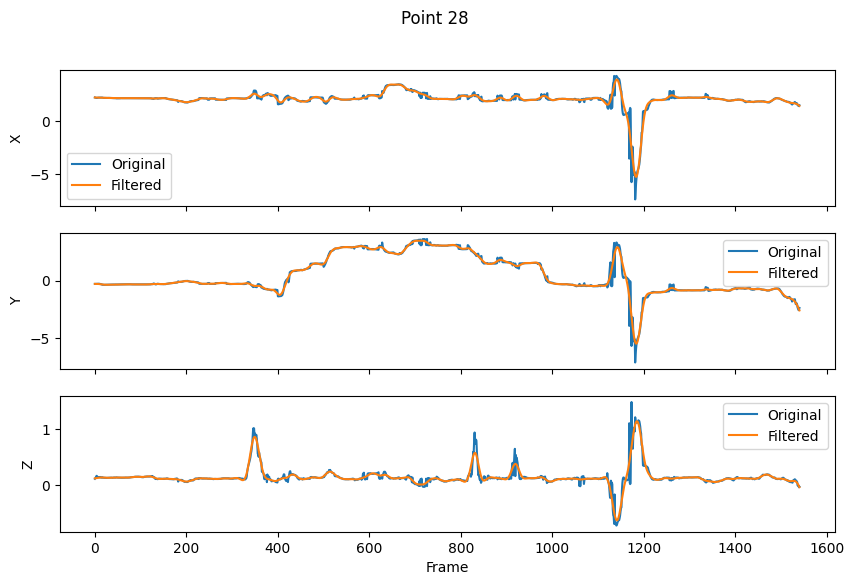

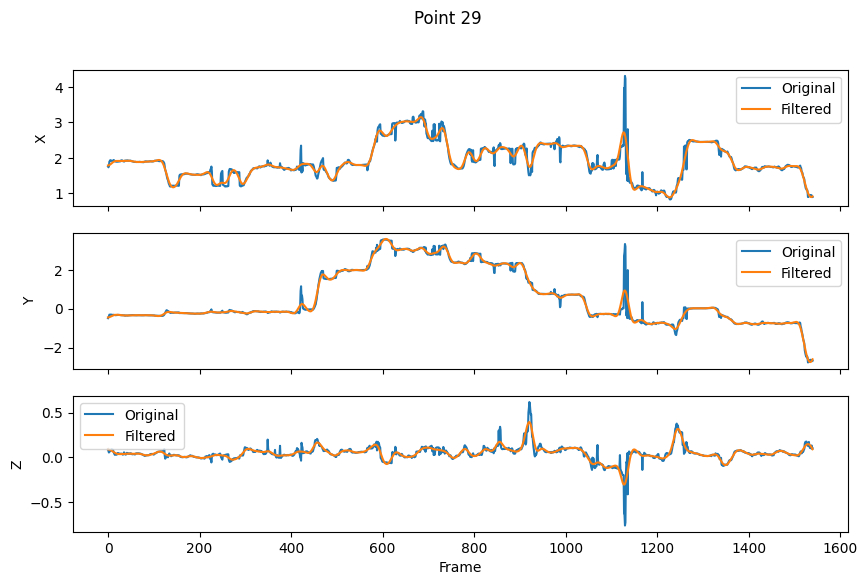

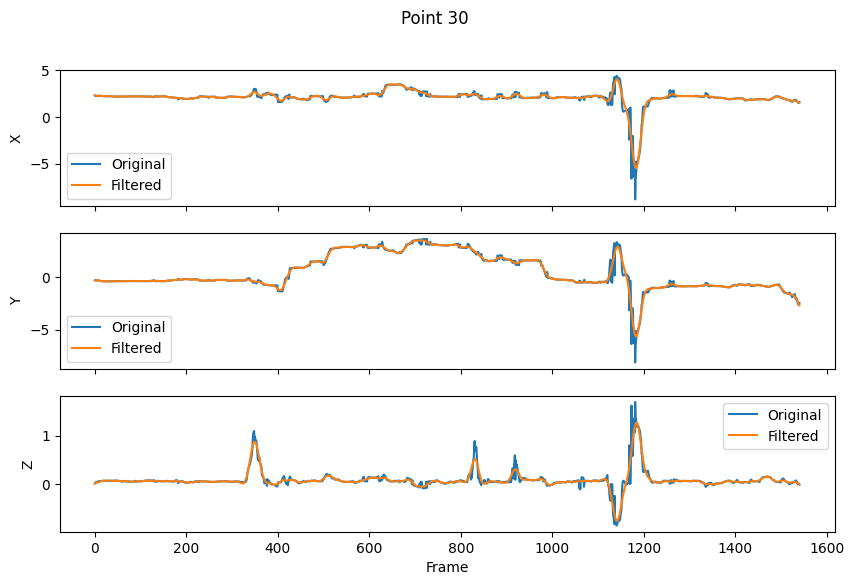

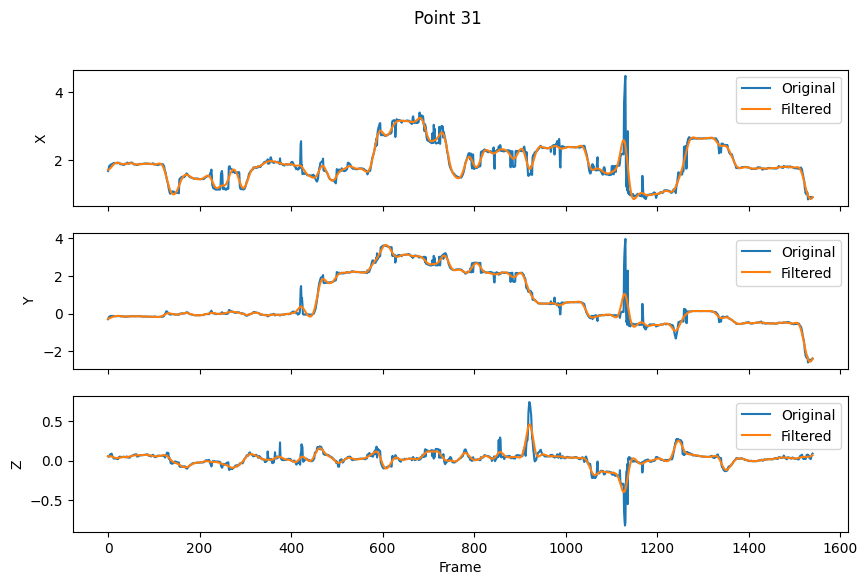

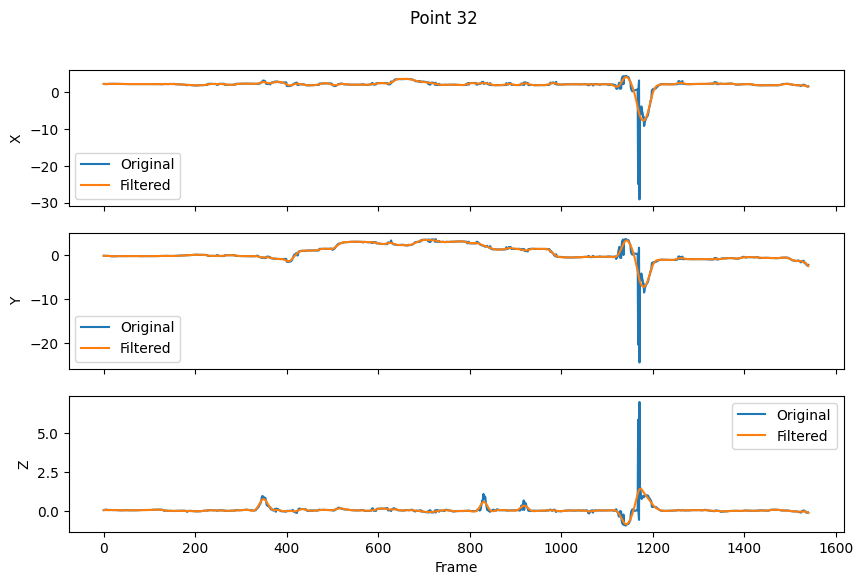

Отфильтрованные координаты сохранены в 'filtered_coords-old.npy'
Форма отфильтрованных координат: (1541, 33, 3)
Форма восстановленных координат: (1743, 33, 3)


In [ ]:
#@title Восстанавливаем размерность массива
# Исходные данные
print("Исходная форма данных:", frames_3d.shape)

# Шаг 1: Создание маски для строк без NaN
mask = ~np.all(np.isnan(frames_3d), axis=(1, 2))

# Удаление строк с NaN
frames_3d_not_nan = frames_3d[mask]
print("Форма данных после удаления строк с NaN:", frames_3d_not_nan.shape)

# Шаг 2: Фильтрация данных
filtered_coords = filter_all(frames_3d_not_nan, config_dict)
print("Форма отфильтрованных координат:", filtered_coords.shape)

# Шаг 3: Восстановление исходной размерности
restored_coords = np.full_like(frames_3d, np.nan)
restored_coords[mask] = filtered_coords

# Проверка результата
print("Форма восстановленных координат:", restored_coords.shape)

In [ ]:
!cp /content/filtered_coords-old.npy /content/drive/MyDrive/Karate_2/old_video/

In [ ]:
frames_3d = np.load('/content/drive/MyDrive/Karate_2/old_video/frames_3d-old.npy')

In [ ]:
frames_3d = restored_coords

In [ ]:
frames_3d.shape

(1743, 33, 3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета
def plot_skeleton(frame_index):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return

    # Отображение точек
    x, y, z = valid_keypoints[:, 0], valid_keypoints[:, 1], valid_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(keypoints) and end < len(keypoints) and
                not np.any(np.isnan(keypoints[start])) and not np.any(np.isnan(keypoints[end]))):
            xs = [keypoints[start][0], keypoints[end][0]]
            ys = [keypoints[start][1], keypoints[end][1]]
            zs = [keypoints[start][2], keypoints[end][2]]
            ax.plot(xs, ys, zs, c='blue')

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Ограничение оси X: минимальное значение -10, максимальное — рассчитывается
        ax.set_xlim(-1, 5)
        ax.set_ylim(-1, 5)
        ax.set_zlim(np.min(valid_z), 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    plt.show()

# Создание слайдера для выбора кадра
num_frames = frames_3d.shape[0]  # Общее количество кадров
frame_slider = IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame Index")

# Привязка функции plot_skeleton к слайдеру
interact(plot_skeleton, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame Index', max=1742), Output()), _dom_classes=('widge…

<function __main__.plot_skeleton(frame_index)>

In [ ]:
#@title Отображаем предыдущий скелет, если не найдены точки
import os
import subprocess
import shutil
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import gc

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для генерации кадров
def generate_frames(frames_3d, output_dir, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)

    num_frames = frames_3d.shape[0]  # Общее количество кадров
    print(f"Общее количество кадров: {num_frames}")

    # Переменная для хранения последнего успешно сгенерированного изображения
    last_successful_image = None

    for batch_start in range(0, num_frames, batch_size):
        batch_end = min(batch_start + batch_size, num_frames)
        print(f"Обработка пакета: {batch_start} - {batch_end}")

        # Создание нового графика для каждого пакета
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111, projection='3d')
        plt.ioff()  # Отключаем интерактивный режим

        for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
            # Очистка предыдущего кадра
            ax.clear()

            try:
                # Извлечение координат для выбранного кадра
                keypoints = frames_3d[frame_index]  # (33, 3)

                # Проверка данных
                if np.isnan(keypoints).any() or np.isinf(keypoints).any():
                    raise ValueError(f"Некорректные данные для кадра {frame_index}")

                # Отображение точек
                x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
                ax.scatter(x, y, z, c='red', s=10)

                # Отображение связей между точками
                for start, end in connections:
                    xs = [keypoints[start][0], keypoints[end][0]]
                    ys = [keypoints[start][1], keypoints[end][1]]
                    zs = [keypoints[start][2], keypoints[end][2]]
                    ax.plot(xs, ys, zs, c='blue')

                # Настройка осей на основе данных
                all_x = frames_3d[:, :, 0].flatten()
                all_y = frames_3d[:, :, 1].flatten()
                all_z = frames_3d[:, :, 2].flatten()

                # Исключаем NaN и Inf при расчете пределов осей
                valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
                valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
                valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

                if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
                    # Ограничение оси X: минимальное значение -10, максимальное — рассчитывается
                    ax.set_xlim(-1, 5)
                    ax.set_ylim(-1, 5)
                    ax.set_zlim(np.min(valid_z), 2)
                else:
                    raise ValueError("No valid data to set axis limits.")

                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_title(f"Frame {frame_index}")

                # Сохранение кадра
                frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение

                # Сохраняем последнее успешное изображение
                last_successful_image = frame_path

            except Exception as e:
                # Если произошла ошибка, используем последнее успешное изображение
                if last_successful_image:
                    frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                    shutil.copy(last_successful_image, frame_path)
                    print(f"Использовано предыдущее изображение для кадра {frame_index}: {last_successful_image}")
                else:
                    print(f"Невозможно сгенерировать кадр {frame_index}: {e}")

        # Очистка памяти после обработки пакета
        plt.close(fig)
        gc.collect()

# Функция для изменения размеров изображений
def adjust_image_sizes(output_dir, target_size):
    """
    Изменяет размеры всех изображений в директории до целевого размера.
    :param output_dir: Директория с изображениями.
    :param target_size: Целевой размер (ширина, высота).
    """
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size)
            img_resized.save(img_path)

# Генерация кадров
output_dir = "/content/frames"
generate_frames(frames_3d, output_dir)

# Корректировка размеров изображений
original_width, original_height = plt.gcf().get_size_inches() * plt.gcf().dpi
target_size = (int(original_width // 2 * 2), int(original_height // 2 * 2))  # Размеры, кратные 2
adjust_image_sizes(output_dir, target_size)

print(f"Размеры изображений изменены на {target_size}.")

Общее количество кадров: 1743
Обработка пакета: 0 - 100


Генерация кадров:  10%|█         | 10/100 [00:00<00:00, 95.26frame/s]

Невозможно сгенерировать кадр 0: Некорректные данные для кадра 0
Невозможно сгенерировать кадр 1: Некорректные данные для кадра 1
Невозможно сгенерировать кадр 2: Некорректные данные для кадра 2
Невозможно сгенерировать кадр 3: Некорректные данные для кадра 3
Невозможно сгенерировать кадр 4: Некорректные данные для кадра 4
Невозможно сгенерировать кадр 5: Некорректные данные для кадра 5
Невозможно сгенерировать кадр 6: Некорректные данные для кадра 6
Невозможно сгенерировать кадр 7: Некорректные данные для кадра 7
Невозможно сгенерировать кадр 8: Некорректные данные для кадра 8
Невозможно сгенерировать кадр 9: Некорректные данные для кадра 9
Невозможно сгенерировать кадр 10: Некорректные данные для кадра 10
Невозможно сгенерировать кадр 11: Некорректные данные для кадра 11
Невозможно сгенерировать кадр 12: Некорректные данные для кадра 12
Невозможно сгенерировать кадр 13: Некорректные данные для кадра 13
Невозможно сгенерировать кадр 14: Некорректные данные для кадра 14
Невозможно сген

Генерация кадров:  21%|██        | 21/100 [00:00<00:00, 99.00frame/s]

Невозможно сгенерировать кадр 18: Некорректные данные для кадра 18
Невозможно сгенерировать кадр 19: Некорректные данные для кадра 19
Невозможно сгенерировать кадр 20: Некорректные данные для кадра 20


Генерация кадров:  31%|███       | 31/100 [00:00<00:00, 96.84frame/s]

Невозможно сгенерировать кадр 21: Некорректные данные для кадра 21
Невозможно сгенерировать кадр 22: Некорректные данные для кадра 22
Невозможно сгенерировать кадр 23: Некорректные данные для кадра 23
Невозможно сгенерировать кадр 24: Некорректные данные для кадра 24
Невозможно сгенерировать кадр 25: Некорректные данные для кадра 25
Невозможно сгенерировать кадр 26: Некорректные данные для кадра 26
Невозможно сгенерировать кадр 27: Некорректные данные для кадра 27
Невозможно сгенерировать кадр 28: Некорректные данные для кадра 28
Невозможно сгенерировать кадр 29: Некорректные данные для кадра 29
Невозможно сгенерировать кадр 30: Некорректные данные для кадра 30
Невозможно сгенерировать кадр 31: Некорректные данные для кадра 31
Невозможно сгенерировать кадр 32: Некорректные данные для кадра 32
Невозможно сгенерировать кадр 33: Некорректные данные для кадра 33
Невозможно сгенерировать кадр 34: Некорректные данные для кадра 34
Невозможно сгенерировать кадр 35: Некорректные данные для кадр

Генерация кадров:  41%|████      | 41/100 [00:00<00:00, 93.50frame/s]

Невозможно сгенерировать кадр 39: Некорректные данные для кадра 39
Невозможно сгенерировать кадр 40: Некорректные данные для кадра 40


Генерация кадров:  51%|█████     | 51/100 [00:00<00:00, 93.05frame/s]

Невозможно сгенерировать кадр 41: Некорректные данные для кадра 41
Невозможно сгенерировать кадр 42: Некорректные данные для кадра 42
Невозможно сгенерировать кадр 43: Некорректные данные для кадра 43
Невозможно сгенерировать кадр 44: Некорректные данные для кадра 44
Невозможно сгенерировать кадр 45: Некорректные данные для кадра 45
Невозможно сгенерировать кадр 46: Некорректные данные для кадра 46
Невозможно сгенерировать кадр 47: Некорректные данные для кадра 47
Невозможно сгенерировать кадр 48: Некорректные данные для кадра 48
Невозможно сгенерировать кадр 49: Некорректные данные для кадра 49
Невозможно сгенерировать кадр 50: Некорректные данные для кадра 50
Невозможно сгенерировать кадр 51: Некорректные данные для кадра 51
Невозможно сгенерировать кадр 52: Некорректные данные для кадра 52
Невозможно сгенерировать кадр 53: Некорректные данные для кадра 53
Невозможно сгенерировать кадр 54: Некорректные данные для кадра 54
Невозможно сгенерировать кадр 55: Некорректные данные для кадр

Генерация кадров:  62%|██████▏   | 62/100 [00:00<00:00, 95.41frame/s]

Невозможно сгенерировать кадр 59: Некорректные данные для кадра 59
Невозможно сгенерировать кадр 60: Некорректные данные для кадра 60
Невозможно сгенерировать кадр 61: Некорректные данные для кадра 61


Генерация кадров:  72%|███████▏  | 72/100 [00:00<00:00, 93.86frame/s]

Невозможно сгенерировать кадр 62: Некорректные данные для кадра 62
Невозможно сгенерировать кадр 63: Некорректные данные для кадра 63
Невозможно сгенерировать кадр 64: Некорректные данные для кадра 64
Невозможно сгенерировать кадр 65: Некорректные данные для кадра 65
Невозможно сгенерировать кадр 66: Некорректные данные для кадра 66
Невозможно сгенерировать кадр 67: Некорректные данные для кадра 67
Невозможно сгенерировать кадр 68: Некорректные данные для кадра 68
Невозможно сгенерировать кадр 69: Некорректные данные для кадра 69
Невозможно сгенерировать кадр 70: Некорректные данные для кадра 70
Невозможно сгенерировать кадр 71: Некорректные данные для кадра 71
Невозможно сгенерировать кадр 72: Некорректные данные для кадра 72
Невозможно сгенерировать кадр 73: Некорректные данные для кадра 73
Невозможно сгенерировать кадр 74: Некорректные данные для кадра 74
Невозможно сгенерировать кадр 75: Некорректные данные для кадра 75
Невозможно сгенерировать кадр 76: Некорректные данные для кадр

Генерация кадров:  82%|████████▏ | 82/100 [00:00<00:00, 94.34frame/s]

Невозможно сгенерировать кадр 81: Некорректные данные для кадра 81


Генерация кадров: 100%|██████████| 100/100 [00:01<00:00, 95.02frame/s]

Невозможно сгенерировать кадр 82: Некорректные данные для кадра 82
Невозможно сгенерировать кадр 83: Некорректные данные для кадра 83
Невозможно сгенерировать кадр 84: Некорректные данные для кадра 84
Невозможно сгенерировать кадр 85: Некорректные данные для кадра 85
Невозможно сгенерировать кадр 86: Некорректные данные для кадра 86
Невозможно сгенерировать кадр 87: Некорректные данные для кадра 87
Невозможно сгенерировать кадр 88: Некорректные данные для кадра 88
Невозможно сгенерировать кадр 89: Некорректные данные для кадра 89
Невозможно сгенерировать кадр 90: Некорректные данные для кадра 90
Невозможно сгенерировать кадр 91: Некорректные данные для кадра 91
Невозможно сгенерировать кадр 92: Некорректные данные для кадра 92
Невозможно сгенерировать кадр 93: Некорректные данные для кадра 93
Невозможно сгенерировать кадр 94: Некорректные данные для кадра 94
Невозможно сгенерировать кадр 95: Некорректные данные для кадра 95
Невозможно сгенерировать кадр 96: Некорректные данные для кадр


Генерация кадров:  22%|██▏       | 22/100 [00:00<00:00, 104.23frame/s]

Невозможно сгенерировать кадр 100: Некорректные данные для кадра 100
Невозможно сгенерировать кадр 101: Некорректные данные для кадра 101
Невозможно сгенерировать кадр 102: Некорректные данные для кадра 102
Невозможно сгенерировать кадр 103: Некорректные данные для кадра 103
Невозможно сгенерировать кадр 104: Некорректные данные для кадра 104
Невозможно сгенерировать кадр 105: Некорректные данные для кадра 105
Невозможно сгенерировать кадр 106: Некорректные данные для кадра 106
Невозможно сгенерировать кадр 107: Некорректные данные для кадра 107
Невозможно сгенерировать кадр 108: Некорректные данные для кадра 108
Невозможно сгенерировать кадр 109: Некорректные данные для кадра 109
Невозможно сгенерировать кадр 110: Некорректные данные для кадра 110
Невозможно сгенерировать кадр 111: Некорректные данные для кадра 111
Невозможно сгенерировать кадр 112: Некорректные данные для кадра 112
Невозможно сгенерировать кадр 113: Некорректные данные для кадра 113
Невозможно сгенерировать кадр 114:

Генерация кадров:  33%|███▎      | 33/100 [00:00<00:00, 93.68frame/s] 

Невозможно сгенерировать кадр 122: Некорректные данные для кадра 122
Невозможно сгенерировать кадр 123: Некорректные данные для кадра 123
Невозможно сгенерировать кадр 124: Некорректные данные для кадра 124
Невозможно сгенерировать кадр 125: Некорректные данные для кадра 125
Невозможно сгенерировать кадр 126: Некорректные данные для кадра 126
Невозможно сгенерировать кадр 127: Некорректные данные для кадра 127
Невозможно сгенерировать кадр 128: Некорректные данные для кадра 128
Невозможно сгенерировать кадр 129: Некорректные данные для кадра 129
Невозможно сгенерировать кадр 130: Некорректные данные для кадра 130
Невозможно сгенерировать кадр 131: Некорректные данные для кадра 131
Невозможно сгенерировать кадр 132: Некорректные данные для кадра 132
Невозможно сгенерировать кадр 133: Некорректные данные для кадра 133
Невозможно сгенерировать кадр 134: Некорректные данные для кадра 134
Невозможно сгенерировать кадр 135: Некорректные данные для кадра 135
Невозможно сгенерировать кадр 136:

Генерация кадров:  54%|█████▍    | 54/100 [00:00<00:00, 96.91frame/s]

Невозможно сгенерировать кадр 142: Некорректные данные для кадра 142
Невозможно сгенерировать кадр 143: Некорректные данные для кадра 143
Невозможно сгенерировать кадр 144: Некорректные данные для кадра 144
Невозможно сгенерировать кадр 145: Некорректные данные для кадра 145
Невозможно сгенерировать кадр 146: Некорректные данные для кадра 146
Невозможно сгенерировать кадр 147: Некорректные данные для кадра 147
Невозможно сгенерировать кадр 148: Некорректные данные для кадра 148
Невозможно сгенерировать кадр 149: Некорректные данные для кадра 149
Невозможно сгенерировать кадр 150: Некорректные данные для кадра 150
Невозможно сгенерировать кадр 151: Некорректные данные для кадра 151
Невозможно сгенерировать кадр 152: Некорректные данные для кадра 152
Невозможно сгенерировать кадр 153: Некорректные данные для кадра 153
Невозможно сгенерировать кадр 154: Некорректные данные для кадра 154
Невозможно сгенерировать кадр 155: Некорректные данные для кадра 155
Невозможно сгенерировать кадр 156:

Генерация кадров:  65%|██████▌   | 65/100 [00:00<00:00, 98.19frame/s]

Невозможно сгенерировать кадр 164: Некорректные данные для кадра 164
Невозможно сгенерировать кадр 165: Некорректные данные для кадра 165
Невозможно сгенерировать кадр 166: Некорректные данные для кадра 166
Невозможно сгенерировать кадр 167: Некорректные данные для кадра 167
Невозможно сгенерировать кадр 168: Некорректные данные для кадра 168
Невозможно сгенерировать кадр 169: Некорректные данные для кадра 169
Невозможно сгенерировать кадр 170: Некорректные данные для кадра 170
Невозможно сгенерировать кадр 171: Некорректные данные для кадра 171
Невозможно сгенерировать кадр 172: Некорректные данные для кадра 172
Невозможно сгенерировать кадр 173: Некорректные данные для кадра 173
Невозможно сгенерировать кадр 174: Некорректные данные для кадра 174


Генерация кадров: 100%|██████████| 100/100 [00:06<00:00, 14.32frame/s]


Обработка пакета: 200 - 300


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.69frame/s]


Обработка пакета: 300 - 400


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.35frame/s]


Обработка пакета: 400 - 500


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.45frame/s]


Обработка пакета: 500 - 600


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.65frame/s]


Обработка пакета: 600 - 700


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.46frame/s]


Обработка пакета: 700 - 800


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.44frame/s]


Обработка пакета: 800 - 900


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.32frame/s]


Обработка пакета: 900 - 1000


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.49frame/s]


Обработка пакета: 1000 - 1100


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.71frame/s]


Обработка пакета: 1100 - 1200


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.50frame/s]


Обработка пакета: 1200 - 1300


Генерация кадров: 100%|██████████| 100/100 [00:20<00:00,  4.77frame/s]


Обработка пакета: 1300 - 1400


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.46frame/s]


Обработка пакета: 1400 - 1500


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.53frame/s]


Обработка пакета: 1500 - 1600


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.65frame/s]


Обработка пакета: 1600 - 1700


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.45frame/s]


Обработка пакета: 1700 - 1743


Генерация кадров:  84%|████████▎ | 36/43 [00:03<00:00, 38.16frame/s]

Использовано предыдущее изображение для кадра 1716: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1717: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1718: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1719: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1720: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1721: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1722: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1723: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1724: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1725: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1726: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1727: /content/frames/frame_1715.jpg
Испо

Генерация кадров: 100%|██████████| 43/43 [00:03<00:00, 12.64frame/s]


Использовано предыдущее изображение для кадра 1736: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1737: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1738: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1739: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1740: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1741: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1742: /content/frames/frame_1715.jpg
Размеры изображений изменены на (640, 480).


In [ ]:
import os
import subprocess

# Убедитесь, что все изображения переименованы в формат frame_%04d.jpg
output_dir = "/content/frames"
for i, filename in enumerate(sorted(os.listdir(output_dir))):
    if filename.endswith(".jpg"):
        new_name = f"frame_{i:04d}.jpg"
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_name))

# Создание видео с помощью FFmpeg
result = subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "-y",  # Перезапись файла
    "/content/output_filt.mp4"
], capture_output=True, text=True)

# Вывод логов
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

print("Видео успешно создано: /content/output_filt.mp4")

STDOUT: 
STDERR: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --ena

In [ ]:
!rm /content/frames/*

In [ ]:
!cp /content/output_filt.mp4 /content/drive/MyDrive/Karate_2/old_video/

In [ ]:
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'

In [ ]:
# Установка библиотек
!pip install moviepy

# Импорт библиотек
from moviepy.editor import VideoFileClip, clips_array

# Пути к видеофайлам
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'

# Загрузка видео
clip1 = VideoFileClip(video_1)
clip2 = VideoFileClip(video_2)

# Комбинирование видео (горизонтальное расположение)
final_clip = clips_array([[clip1, clip2]])

# Путь для сохранения результата
output_path = '/content/drive/MyDrive/Karate_2/combined_video.mp4'

# Сохранение видео
final_clip.write_videofile(output_path, codec="libx264", fps=clip1.fps)

print(f"Комбинированное видео сохранено в: {output_path}")

  if event.key is 'enter':



Moviepy - Building video /content/drive/MyDrive/Karate_2/combined_video.mp4.
Moviepy - Writing video /content/drive/MyDrive/Karate_2/combined_video.mp4



t: 100%|██████████| 1569/1569 [00:39<00:00, 34.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Karate_2/old_video/output_filt.mp4, 921600 bytes wanted but 0 bytes read,at frame 1568/1569, at time 52.27/52.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Karate_2/combined_video.mp4
Комбинированное видео сохранено в: /content/drive/MyDrive/Karate_2/combined_video.mp4


In [ ]:
#@title Применение нескольких фильтов
def filter1d(col, config_dict, filter_types, frame_rate):
    col_filtered = col.copy()  # Начальные данные
    for filter_type in filter_types:
        filter_mapping = {
            'kalman': kalman_filter_1d,
            'butterworth': butterworth_filter_1d,
            'gaussian': gaussian_filter_1d,
            'LOESS': loess_filter_1d,
            'median': median_filter_1d
        }
        filter_fun = filter_mapping.get(filter_type)
        if filter_fun:
            col_filtered = filter_fun(config_dict, frame_rate, col_filtered)
    return col_filtered

def filter_all(frames_3d, config_dict):
    frame_rate = config_dict.get('frame_rate')
    display_figures = config_dict.get('filtering').get('display_figures')

    # Сохраняем маску для строк без NaN
    mask = ~np.all(np.isnan(frames_3d), axis=(1, 2))

    # Преобразование frames_3d в DataFrame
    n_frames, n_points, _ = frames_3d.shape
    columns = [f'Point_{i}_{axis}' for i in range(n_points) for axis in ['X', 'Y', 'Z']]
    df = pd.DataFrame(frames_3d.reshape(n_frames, -1), columns=columns)

    # Фильтрация
    filter_types = ['median', 'butterworth', 'kalman']  # Цепочка фильтров
    df_filtered = df.apply(filter1d, axis=0, args=[config_dict, filter_types, frame_rate])

    # Восстановление до исходной размерности
    restored_df = pd.DataFrame(np.full_like(df.to_numpy(), np.nan), columns=columns)
    restored_df.loc[mask] = df_filtered.loc[mask]

    # Визуализация
    if display_figures:
        for point_id in range(n_points):
            fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
            for ax, axis in zip(axes, ['X', 'Y', 'Z']):
                ax.plot(df[f'Point_{point_id}_{axis}'], label='Original')
                ax.plot(restored_df[f'Point_{point_id}_{axis}'], label='Filtered')
                ax.set_ylabel(axis)
                ax.legend()
            plt.xlabel('Frame')
            plt.suptitle(f'Point {point_id}')
            plt.show()

    # Сохранение результатов
    filtered_coords = restored_df.to_numpy().reshape(n_frames, n_points, 3)
    np.save('filtered_coords.npy', filtered_coords)
    print("Отфильтрованные координаты сохранены в 'filtered_coords.npy'")
    return filtered_coords

In [ ]:
#@title Восстанавливаем размерность массива
# Исходные данные
print("Исходная форма данных:", frames_3d.shape)

# Шаг 1: Создание маски для строк без NaN
mask = ~np.all(np.isnan(frames_3d), axis=(1, 2))

# Удаление строк с NaN
frames_3d_not_nan = frames_3d[mask]
print("Форма данных после удаления строк с NaN:", frames_3d_not_nan.shape)

# Шаг 2: Фильтрация данных
filtered_coords = filter_all(frames_3d_not_nan, config_dict)
print("Форма отфильтрованных координат:", filtered_coords.shape)

# Шаг 3: Восстановление исходной размерности
restored_coords = np.full_like(frames_3d, np.nan)
restored_coords[mask] = filtered_coords

# Проверка результата
print("Форма восстановленных координат:", restored_coords.shape)

Исходная форма данных: (1743, 33, 3)
Форма данных после удаления строк с NaN: (1541, 33, 3)
Отфильтрованные координаты сохранены в 'filtered_coords.npy'
Форма отфильтрованных координат: (1541, 33, 3)
Форма восстановленных координат: (1743, 33, 3)


In [ ]:
#@title Кинематическая коррекция
import numpy as np

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

def compute_distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками."""
    return np.linalg.norm(p1 - p2)

def calculate_average_bone_lengths(frames_3d, connections):
    """
    Вычисляет средние длины костей по всем кадрам.

    :param frames_3d: Массив координат размерности (n_frames, n_points, 3).
    :param connections: Список пар индексов точек, представляющих "кости".
    :return: Словарь с средними длинами костей.
    """
    bone_lengths = {}
    n_frames, _, _ = frames_3d.shape

    for bone in connections:
        p1, p2 = bone
        distances = []

        for frame in range(n_frames):
            if not (np.any(np.isnan(frames_3d[frame, p1])) or np.any(np.isnan(frames_3d[frame, p2]))):
                distances.append(compute_distance(frames_3d[frame, p1], frames_3d[frame, p2]))

        if distances:
            bone_lengths[bone] = np.mean(distances)
        else:
            bone_lengths[bone] = None  # Если нет данных для кости

    return bone_lengths

def correct_bone_length(frames_3d, connections, tolerance=0.1):
    """
    Корректирует длины "костей" в данных.

    :param frames_3d: Массив координат размерности (n_frames, n_points, 3).
    :param connections: Список пар индексов точек, представляющих "кости".
    :param tolerance: Допустимое отклонение длины кости (в долях от средней длины).
    :return: Исправленный массив координат.
    """
    corrected_frames = frames_3d.copy()
    n_frames, _, _ = frames_3d.shape

    # Вычисляем средние длины костей
    bone_lengths = calculate_average_bone_lengths(frames_3d, connections)

    # Корректируем длины костей для каждого кадра
    for frame in range(n_frames):
        for bone in connections:
            p1, p2 = bone
            expected_length = bone_lengths[bone]

            if expected_length is None:  # Пропускаем кость, если нет данных
                continue

            actual_length = compute_distance(corrected_frames[frame, p1], corrected_frames[frame, p2])

            # Проверяем, выходит ли длина за допустимый диапазон
            if abs(actual_length - expected_length) > tolerance * expected_length:
                # Корректируем положение второй точки
                direction = (corrected_frames[frame, p2] - corrected_frames[frame, p1]) / actual_length
                corrected_frames[frame, p2] = corrected_frames[frame, p1] + direction * expected_length

    return corrected_frames

# Пример использования
# Исходные данные (frames_3d.shape
print (frames_3d.shape)

# Применяем кинематическую коррекцию
tolerance = 0.1  # 10% допустимого отклонения
corrected_coords = correct_bone_length(frames_3d, connections, tolerance)

# Сохраняем исправленные координаты
np.save('corrected_coords.npy', corrected_coords)
print("Исправленные координаты сохранены в 'corrected_coords.npy'")


(1743, 33, 3)
Исправленные координаты сохранены в 'corrected_coords.npy'


In [ ]:
!rm /content/frames/*

In [ ]:
frames_3d = corrected_coords

In [ ]:
#@title Отображаем предыдущий скелет, если не найдены точки
import os
import subprocess
import shutil
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import gc

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для генерации кадров
def generate_frames(frames_3d, output_dir, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)

    num_frames = frames_3d.shape[0]  # Общее количество кадров
    print(f"Общее количество кадров: {num_frames}")

    # Переменная для хранения последнего успешно сгенерированного изображения
    last_successful_image = None

    for batch_start in range(0, num_frames, batch_size):
        batch_end = min(batch_start + batch_size, num_frames)
        print(f"Обработка пакета: {batch_start} - {batch_end}")

        # Создание нового графика для каждого пакета
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111, projection='3d')
        plt.ioff()  # Отключаем интерактивный режим

        for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
            # Очистка предыдущего кадра
            ax.clear()

            try:
                # Извлечение координат для выбранного кадра
                keypoints = frames_3d[frame_index]  # (33, 3)

                # Проверка данных
                if np.isnan(keypoints).any() or np.isinf(keypoints).any():
                    raise ValueError(f"Некорректные данные для кадра {frame_index}")

                # Отображение точек
                x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
                ax.scatter(x, y, z, c='red', s=10)

                # Отображение связей между точками
                for start, end in connections:
                    xs = [keypoints[start][0], keypoints[end][0]]
                    ys = [keypoints[start][1], keypoints[end][1]]
                    zs = [keypoints[start][2], keypoints[end][2]]
                    ax.plot(xs, ys, zs, c='blue')

                # Настройка осей на основе данных
                all_x = frames_3d[:, :, 0].flatten()
                all_y = frames_3d[:, :, 1].flatten()
                all_z = frames_3d[:, :, 2].flatten()

                # Исключаем NaN и Inf при расчете пределов осей
                valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
                valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
                valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

                if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
                    # Ограничение оси X: минимальное значение -10, максимальное — рассчитывается
                    ax.set_xlim(-1, 5)
                    ax.set_ylim(-1, 5)
                    ax.set_zlim(np.min(valid_z), 2)
                else:
                    raise ValueError("No valid data to set axis limits.")

                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_title(f"Frame {frame_index}")

                # Сохранение кадра
                frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение

                # Сохраняем последнее успешное изображение
                last_successful_image = frame_path

            except Exception as e:
                # Если произошла ошибка, используем последнее успешное изображение
                if last_successful_image:
                    frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                    shutil.copy(last_successful_image, frame_path)
                    print(f"Использовано предыдущее изображение для кадра {frame_index}: {last_successful_image}")
                else:
                    print(f"Невозможно сгенерировать кадр {frame_index}: {e}")

        # Очистка памяти после обработки пакета
        plt.close(fig)
        gc.collect()

# Функция для изменения размеров изображений
def adjust_image_sizes(output_dir, target_size):
    """
    Изменяет размеры всех изображений в директории до целевого размера.
    :param output_dir: Директория с изображениями.
    :param target_size: Целевой размер (ширина, высота).
    """
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size)
            img_resized.save(img_path)

# Генерация кадров
output_dir = "/content/frames"
generate_frames(frames_3d, output_dir)

# Корректировка размеров изображений
original_width, original_height = plt.gcf().get_size_inches() * plt.gcf().dpi
target_size = (int(original_width // 2 * 2), int(original_height // 2 * 2))  # Размеры, кратные 2
adjust_image_sizes(output_dir, target_size)

print(f"Размеры изображений изменены на {target_size}.")

Общее количество кадров: 1743
Обработка пакета: 0 - 100


Генерация кадров:  11%|█         | 11/100 [00:00<00:00, 105.53frame/s]

Невозможно сгенерировать кадр 0: Некорректные данные для кадра 0
Невозможно сгенерировать кадр 1: Некорректные данные для кадра 1
Невозможно сгенерировать кадр 2: Некорректные данные для кадра 2
Невозможно сгенерировать кадр 3: Некорректные данные для кадра 3
Невозможно сгенерировать кадр 4: Некорректные данные для кадра 4
Невозможно сгенерировать кадр 5: Некорректные данные для кадра 5
Невозможно сгенерировать кадр 6: Некорректные данные для кадра 6
Невозможно сгенерировать кадр 7: Некорректные данные для кадра 7
Невозможно сгенерировать кадр 8: Некорректные данные для кадра 8
Невозможно сгенерировать кадр 9: Некорректные данные для кадра 9
Невозможно сгенерировать кадр 10: Некорректные данные для кадра 10
Невозможно сгенерировать кадр 11: Некорректные данные для кадра 11
Невозможно сгенерировать кадр 12: Некорректные данные для кадра 12
Невозможно сгенерировать кадр 13: Некорректные данные для кадра 13
Невозможно сгенерировать кадр 14: Некорректные данные для кадра 14
Невозможно сген

Генерация кадров:  33%|███▎      | 33/100 [00:00<00:00, 97.58frame/s]

Невозможно сгенерировать кадр 21: Некорректные данные для кадра 21
Невозможно сгенерировать кадр 22: Некорректные данные для кадра 22
Невозможно сгенерировать кадр 23: Некорректные данные для кадра 23
Невозможно сгенерировать кадр 24: Некорректные данные для кадра 24
Невозможно сгенерировать кадр 25: Некорректные данные для кадра 25
Невозможно сгенерировать кадр 26: Некорректные данные для кадра 26
Невозможно сгенерировать кадр 27: Некорректные данные для кадра 27
Невозможно сгенерировать кадр 28: Некорректные данные для кадра 28
Невозможно сгенерировать кадр 29: Некорректные данные для кадра 29
Невозможно сгенерировать кадр 30: Некорректные данные для кадра 30
Невозможно сгенерировать кадр 31: Некорректные данные для кадра 31
Невозможно сгенерировать кадр 32: Некорректные данные для кадра 32
Невозможно сгенерировать кадр 33: Некорректные данные для кадра 33
Невозможно сгенерировать кадр 34: Некорректные данные для кадра 34
Невозможно сгенерировать кадр 35: Некорректные данные для кадр

Генерация кадров:  54%|█████▍    | 54/100 [00:00<00:00, 95.79frame/s]

Невозможно сгенерировать кадр 42: Некорректные данные для кадра 42
Невозможно сгенерировать кадр 43: Некорректные данные для кадра 43
Невозможно сгенерировать кадр 44: Некорректные данные для кадра 44
Невозможно сгенерировать кадр 45: Некорректные данные для кадра 45
Невозможно сгенерировать кадр 46: Некорректные данные для кадра 46
Невозможно сгенерировать кадр 47: Некорректные данные для кадра 47
Невозможно сгенерировать кадр 48: Некорректные данные для кадра 48
Невозможно сгенерировать кадр 49: Некорректные данные для кадра 49
Невозможно сгенерировать кадр 50: Некорректные данные для кадра 50
Невозможно сгенерировать кадр 51: Некорректные данные для кадра 51
Невозможно сгенерировать кадр 52: Некорректные данные для кадра 52
Невозможно сгенерировать кадр 53: Некорректные данные для кадра 53
Невозможно сгенерировать кадр 54: Некорректные данные для кадра 54
Невозможно сгенерировать кадр 55: Некорректные данные для кадра 55
Невозможно сгенерировать кадр 56: Некорректные данные для кадр

Генерация кадров:  75%|███████▌  | 75/100 [00:00<00:00, 96.68frame/s]

Невозможно сгенерировать кадр 63: Некорректные данные для кадра 63
Невозможно сгенерировать кадр 64: Некорректные данные для кадра 64
Невозможно сгенерировать кадр 65: Некорректные данные для кадра 65
Невозможно сгенерировать кадр 66: Некорректные данные для кадра 66
Невозможно сгенерировать кадр 67: Некорректные данные для кадра 67
Невозможно сгенерировать кадр 68: Некорректные данные для кадра 68
Невозможно сгенерировать кадр 69: Некорректные данные для кадра 69
Невозможно сгенерировать кадр 70: Некорректные данные для кадра 70
Невозможно сгенерировать кадр 71: Некорректные данные для кадра 71
Невозможно сгенерировать кадр 72: Некорректные данные для кадра 72
Невозможно сгенерировать кадр 73: Некорректные данные для кадра 73
Невозможно сгенерировать кадр 74: Некорректные данные для кадра 74
Невозможно сгенерировать кадр 75: Некорректные данные для кадра 75
Невозможно сгенерировать кадр 76: Некорректные данные для кадра 76
Невозможно сгенерировать кадр 77: Некорректные данные для кадр

Генерация кадров: 100%|██████████| 100/100 [00:01<00:00, 94.64frame/s]

Невозможно сгенерировать кадр 84: Некорректные данные для кадра 84
Невозможно сгенерировать кадр 85: Некорректные данные для кадра 85
Невозможно сгенерировать кадр 86: Некорректные данные для кадра 86
Невозможно сгенерировать кадр 87: Некорректные данные для кадра 87
Невозможно сгенерировать кадр 88: Некорректные данные для кадра 88
Невозможно сгенерировать кадр 89: Некорректные данные для кадра 89
Невозможно сгенерировать кадр 90: Некорректные данные для кадра 90
Невозможно сгенерировать кадр 91: Некорректные данные для кадра 91
Невозможно сгенерировать кадр 92: Некорректные данные для кадра 92
Невозможно сгенерировать кадр 93: Некорректные данные для кадра 93
Невозможно сгенерировать кадр 94: Некорректные данные для кадра 94
Невозможно сгенерировать кадр 95: Некорректные данные для кадра 95
Невозможно сгенерировать кадр 96: Некорректные данные для кадра 96
Невозможно сгенерировать кадр 97: Некорректные данные для кадра 97
Невозможно сгенерировать кадр 98: Некорректные данные для кадр


Генерация кадров:  18%|█▊        | 18/100 [00:00<00:00, 89.46frame/s]

Невозможно сгенерировать кадр 100: Некорректные данные для кадра 100
Невозможно сгенерировать кадр 101: Некорректные данные для кадра 101
Невозможно сгенерировать кадр 102: Некорректные данные для кадра 102
Невозможно сгенерировать кадр 103: Некорректные данные для кадра 103
Невозможно сгенерировать кадр 104: Некорректные данные для кадра 104
Невозможно сгенерировать кадр 105: Некорректные данные для кадра 105
Невозможно сгенерировать кадр 106: Некорректные данные для кадра 106
Невозможно сгенерировать кадр 107: Некорректные данные для кадра 107
Невозможно сгенерировать кадр 108: Некорректные данные для кадра 108
Невозможно сгенерировать кадр 109: Некорректные данные для кадра 109
Невозможно сгенерировать кадр 110: Некорректные данные для кадра 110
Невозможно сгенерировать кадр 111: Некорректные данные для кадра 111
Невозможно сгенерировать кадр 112: Некорректные данные для кадра 112
Невозможно сгенерировать кадр 113: Некорректные данные для кадра 113
Невозможно сгенерировать кадр 114:

Генерация кадров:  39%|███▉      | 39/100 [00:00<00:00, 94.81frame/s]

Невозможно сгенерировать кадр 119: Некорректные данные для кадра 119
Невозможно сгенерировать кадр 120: Некорректные данные для кадра 120
Невозможно сгенерировать кадр 121: Некорректные данные для кадра 121
Невозможно сгенерировать кадр 122: Некорректные данные для кадра 122
Невозможно сгенерировать кадр 123: Некорректные данные для кадра 123
Невозможно сгенерировать кадр 124: Некорректные данные для кадра 124
Невозможно сгенерировать кадр 125: Некорректные данные для кадра 125
Невозможно сгенерировать кадр 126: Некорректные данные для кадра 126
Невозможно сгенерировать кадр 127: Некорректные данные для кадра 127
Невозможно сгенерировать кадр 128: Некорректные данные для кадра 128
Невозможно сгенерировать кадр 129: Некорректные данные для кадра 129
Невозможно сгенерировать кадр 130: Некорректные данные для кадра 130
Невозможно сгенерировать кадр 131: Некорректные данные для кадра 131
Невозможно сгенерировать кадр 132: Некорректные данные для кадра 132
Невозможно сгенерировать кадр 133:

Генерация кадров:  59%|█████▉    | 59/100 [00:00<00:00, 90.68frame/s]

Невозможно сгенерировать кадр 140: Некорректные данные для кадра 140
Невозможно сгенерировать кадр 141: Некорректные данные для кадра 141
Невозможно сгенерировать кадр 142: Некорректные данные для кадра 142
Невозможно сгенерировать кадр 143: Некорректные данные для кадра 143
Невозможно сгенерировать кадр 144: Некорректные данные для кадра 144
Невозможно сгенерировать кадр 145: Некорректные данные для кадра 145
Невозможно сгенерировать кадр 146: Некорректные данные для кадра 146
Невозможно сгенерировать кадр 147: Некорректные данные для кадра 147
Невозможно сгенерировать кадр 148: Некорректные данные для кадра 148
Невозможно сгенерировать кадр 149: Некорректные данные для кадра 149
Невозможно сгенерировать кадр 150: Некорректные данные для кадра 150
Невозможно сгенерировать кадр 151: Некорректные данные для кадра 151
Невозможно сгенерировать кадр 152: Некорректные данные для кадра 152
Невозможно сгенерировать кадр 153: Некорректные данные для кадра 153
Невозможно сгенерировать кадр 154:

Генерация кадров:  69%|██████▉   | 69/100 [00:00<00:00, 91.25frame/s]

Невозможно сгенерировать кадр 160: Некорректные данные для кадра 160
Невозможно сгенерировать кадр 161: Некорректные данные для кадра 161
Невозможно сгенерировать кадр 162: Некорректные данные для кадра 162
Невозможно сгенерировать кадр 163: Некорректные данные для кадра 163
Невозможно сгенерировать кадр 164: Некорректные данные для кадра 164
Невозможно сгенерировать кадр 165: Некорректные данные для кадра 165
Невозможно сгенерировать кадр 166: Некорректные данные для кадра 166
Невозможно сгенерировать кадр 167: Некорректные данные для кадра 167
Невозможно сгенерировать кадр 168: Некорректные данные для кадра 168
Невозможно сгенерировать кадр 169: Некорректные данные для кадра 169
Невозможно сгенерировать кадр 170: Некорректные данные для кадра 170
Невозможно сгенерировать кадр 171: Некорректные данные для кадра 171
Невозможно сгенерировать кадр 172: Некорректные данные для кадра 172
Невозможно сгенерировать кадр 173: Некорректные данные для кадра 173
Невозможно сгенерировать кадр 174:

Генерация кадров: 100%|██████████| 100/100 [00:06<00:00, 14.90frame/s]


Обработка пакета: 200 - 300


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.46frame/s]


Обработка пакета: 300 - 400


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.31frame/s]


Обработка пакета: 400 - 500


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.55frame/s]


Обработка пакета: 500 - 600


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.38frame/s]


Обработка пакета: 600 - 700


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.25frame/s]


Обработка пакета: 700 - 800


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.66frame/s]


Обработка пакета: 800 - 900


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.39frame/s]


Обработка пакета: 900 - 1000


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.57frame/s]


Обработка пакета: 1000 - 1100


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.41frame/s]


Обработка пакета: 1100 - 1200


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.42frame/s]


Обработка пакета: 1200 - 1300


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.73frame/s]


Обработка пакета: 1300 - 1400


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.47frame/s]


Обработка пакета: 1400 - 1500


Генерация кадров: 100%|██████████| 100/100 [00:21<00:00,  4.61frame/s]


Обработка пакета: 1500 - 1600


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.52frame/s]


Обработка пакета: 1600 - 1700


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.38frame/s]


Обработка пакета: 1700 - 1743


Генерация кадров:  81%|████████▏ | 35/43 [00:03<00:00, 35.84frame/s]

Использовано предыдущее изображение для кадра 1716: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1717: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1718: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1719: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1720: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1721: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1722: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1723: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1724: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1725: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1726: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1727: /content/frames/frame_1715.jpg
Испо

Генерация кадров: 100%|██████████| 43/43 [00:03<00:00, 12.67frame/s]


Использовано предыдущее изображение для кадра 1735: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1736: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1737: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1738: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1739: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1740: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1741: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1742: /content/frames/frame_1715.jpg
Размеры изображений изменены на (640, 480).


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import subprocess

# Убедитесь, что все изображения переименованы в формат frame_%04d.jpg
output_dir = "/content/frames"
for i, filename in enumerate(sorted(os.listdir(output_dir))):
    if filename.endswith(".jpg"):
        new_name = f"frame_{i:04d}.jpg"
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_name))

# Создание видео с помощью FFmpeg
result = subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "-y",  # Перезапись файла
    "/content/output_correct.mp4"
], capture_output=True, text=True)

# Вывод логов
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

print("Видео успешно создано: /content/output_correct.mp4")

STDOUT: 
STDERR: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --ena

In [ ]:
!cp /content/output_correct.mp4 /content/drive/MyDrive/Karate_2/old_video

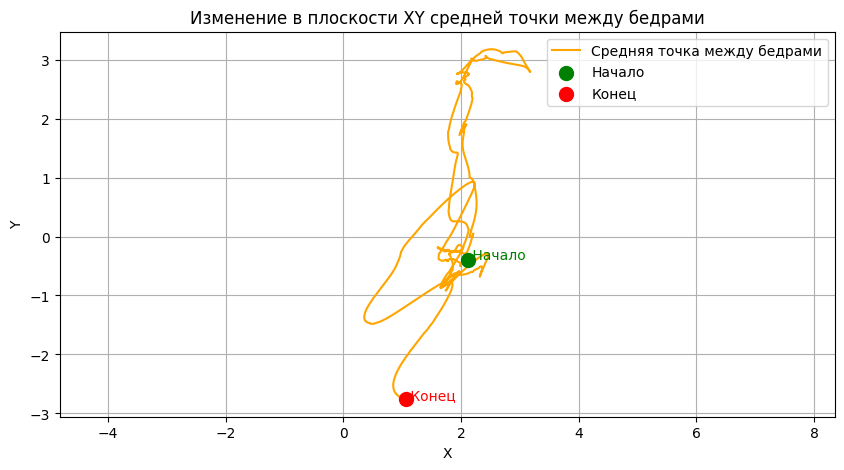

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров
mid_point_x = (frames_3d[:, 23, 0] + frames_3d[:, 24, 0]) / 2
mid_point_y = (frames_3d[:, 23, 1] + frames_3d[:, 24, 1]) / 2

# Исключение NaN из данных
valid_indices = ~np.isnan(mid_point_x) & ~np.isnan(mid_point_y)
mid_point_x_valid = mid_point_x[valid_indices]
mid_point_y_valid = mid_point_y[valid_indices]

# Проверка, что есть хотя бы одна валидная точка
if len(mid_point_x_valid) == 0:
    raise ValueError("Нет валидных данных для построения графика.")

# Определение начала и конца
start_x, start_y = mid_point_x_valid[0], mid_point_y_valid[0]
end_x, end_y = mid_point_x_valid[-1], mid_point_y_valid[-1]

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(mid_point_x_valid, mid_point_y_valid, label="Средняя точка между бедрами", color="orange")

# Добавление точки начала
plt.scatter(start_x, start_y, color="green", s=100, label="Начало", zorder=5)
plt.text(start_x, start_y, " Начало", color="green", fontsize=10)

# Добавление точки конца
plt.scatter(end_x, end_y, color="red", s=100, label="Конец", zorder=5)
plt.text(end_x, end_y, " Конец", color="red", fontsize=10)

# Настройка графика
plt.title("Изменение в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей
plt.show()

In [ ]:
!sudo apt-get update
!sudo apt-get install imagemagick

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
# Открываем файл policy.xml для редактирования
!sudo sed -i 's/rights="none" pattern="PDF"/rights="read|write" pattern="PDF"/g' /etc/ImageMagick-6/policy.xml
!sudo sed -i 's/rights="none" pattern="TEXT"/rights="read|write" pattern="TEXT"/g' /etc/ImageMagick-6/policy.xml
!sudo sed -i 's/rights="none" pattern="LABEL"/rights="read|write" pattern="LABEL"/g' /etc/ImageMagick-6/policy.xml
!sudo sed -i 's/rights="none" pattern="URL"/rights="read|write" pattern="URL"/g' /etc/ImageMagick-6/policy.xml

In [ ]:
!convert --version

Version: ImageMagick 6.9.11-60 Q16 x86_64 2021-01-25 https://imagemagick.org
Copyright: (C) 1999-2021 ImageMagick Studio LLC
License: https://imagemagick.org/script/license.php
Features: Cipher DPC Modules OpenMP(4.5) 
Delegates (built-in): bzlib djvu fftw fontconfig freetype heic jbig jng jp2 jpeg lcms lqr ltdl lzma openexr pangocairo png tiff webp wmf x xml zlib


In [ ]:
!cat /etc/ImageMagick-6/policy.xml

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE policymap [
  <!ELEMENT policymap (policy)*>
  <!ATTLIST policymap xmlns CDATA #FIXED ''>
  <!ELEMENT policy EMPTY>
  <!ATTLIST policy xmlns CDATA #FIXED '' domain NMTOKEN #REQUIRED
    name NMTOKEN #IMPLIED pattern CDATA #IMPLIED rights NMTOKEN #IMPLIED
    stealth NMTOKEN #IMPLIED value CDATA #IMPLIED>
]>
<!--
  Configure ImageMagick policies.

  Domains include system, delegate, coder, filter, path, or resource.

  Rights include none, read, write, execute and all.  Use | to combine them,
  for example: "read | write" to permit read from, or write to, a path.

  Use a glob expression as a pattern.

  Suppose we do not want users to process MPEG video images:

    <policy domain="delegate" rights="none" pattern="mpeg:decode" />

  Here we do not want users reading images from HTTP:

    <policy domain="coder" rights="none" pattern="HTTP" />

  The /repository file system is restricted to read only.  We use a glob
  expression to match 

In [ ]:
from moviepy.config import change_settings

# Указываем путь к ImageMagick
change_settings({"IMAGEMAGICK_BINARY": "/usr/bin/convert"})

In [ ]:
!pip install pillow

In [ ]:
# Скачиваем шрифт Arial
!wget https://github.com/JotJunior/PHP-Boleto-ZF2/raw/master/public/assets/fonts/arial.ttf -O arial.ttf

--2025-03-31 07:40:44--  https://github.com/JotJunior/PHP-Boleto-ZF2/raw/master/public/assets/fonts/arial.ttf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JotJunior/PHP-Boleto-ZF2/master/public/assets/fonts/arial.ttf [following]
--2025-03-31 07:40:44--  https://raw.githubusercontent.com/JotJunior/PHP-Boleto-ZF2/master/public/assets/fonts/arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311636 (304K) [application/octet-stream]
Saving to: ‘arial.ttf’

arial.ttf           100%[===================>] 304.33K  1.75MB/s    in 0.2s    

2025-03-31 07:40:45 (1.75 MB/s) - ‘arial.ttf’ saved [

In [ ]:
# Установка шрифта DejaVu Sans
!sudo apt-get update
!sudo apt-get install -y fonts-dejavu

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
# Установка необходимых библиотек
!pip install moviepy pillow

# Установка шрифта DejaVu Sans
!sudo apt-get update
!sudo apt-get install -y fonts-dejavu

# Импорт библиотек
from moviepy.editor import VideoFileClip, clips_array, CompositeVideoClip
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Функция для создания текстовой подложки с помощью Pillow
def create_text_image(text, width=480, height=40, fontsize=24, text_color="white", bg_color=(0, 0, 0, 0)):
    # Создаем изображение с прозрачным фоном
    img = Image.new("RGBA", (width, height), bg_color)
    draw = ImageDraw.Draw(img)

    # Загружаем шрифт (используем DejaVu Sans, который теперь установлен)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", fontsize)
    except IOError:
        raise OSError("Шрифт не найден. Убедитесь, что шрифт установлен в системе.")

    # Рассчитываем позицию текста (по центру) с использованием textbbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    position = ((width - text_width) // 2, (height - text_height) // 2)

    # Рисуем текст
    draw.text(position, text, fill=text_color, font=font)

    # Преобразуем изображение в массив NumPy
    return np.array(img)

# Пути к исходным видео
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/old_video/output_correct.mp4'

# Загрузка видео
clip1 = VideoFileClip(video_1)
clip2 = VideoFileClip(video_2)
clip3 = VideoFileClip(video_3)

# Обрезка видео до размера 480x480 (центральная часть)
clip1 = clip1.crop(x_center=clip1.w//2, y_center=clip1.h//2, width=480, height=480)
clip2 = clip2.crop(x_center=clip2.w//2, y_center=clip2.h//2, width=480, height=480)
clip3 = clip3.crop(x_center=clip3.w//2, y_center=clip3.h//2, width=480, height=480)

# Выравнивание длительности видео (если они разной длины)
min_duration = min(clip1.duration, clip2.duration, clip3.duration)
clip1 = clip1.subclip(0, min_duration)
clip2 = clip2.subclip(0, min_duration)
clip3 = clip3.subclip(0, min_duration)

# Добавление подписей
def add_text_overlay(video_clip, text):
    # Создаем текстовую подложку
    text_image = create_text_image(text)

    # Преобразуем текстовую подложку в видеоклип
    def make_frame(get_frame, t):
        frame = get_frame(t)  # Получаем текущий кадр видео
        frame_pil = Image.fromarray(frame)
        overlay = Image.fromarray(text_image)
        frame_with_text = Image.alpha_composite(frame_pil.convert("RGBA"), overlay)
        return np.array(frame_with_text)

    return video_clip.fl(make_frame)

# Добавляем подписи к каждому видео
clip1_with_text = add_text_overlay(clip1, "Без фильтрации")
clip2_with_text = add_text_overlay(clip2, "Фильтр Kalman")
clip3_with_text = add_text_overlay(clip3, "Кинематическая коррекция")

# Создание комбинированного видео (в один ряд)
final_clip = clips_array([[clip1_with_text, clip2_with_text, clip3_with_text]])

# Сохранение результата
output_path = '/content/drive/MyDrive/Karate_2/combined_video_with_titles.mp4'
final_clip.write_videofile(output_path, codec="libx264", fps=clip1.fps)

print(f"Комбинированное видео с подписями сохранено по пути: {output_path}")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

ValueError: images do not match

In [ ]:
# Пути к исходным видео
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/old_video/output_correct.mp4'

# Выходной файл
output_path = '/content/drive/MyDrive/Karate_2/combined_video_with_titles_ffmpeg.mp4'

# Команда FFmpeg
!ffmpeg -i "$video_1" -i "$video_2" -i "$video_3" \
-filter_complex \
"[0:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Без фильтрации':fontcolor=white:fontsize=24:x=(w-text_w)/2:y=10[v0]; \
 [1:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Фильтр Kalman':fontcolor=white:fontsize=24:x=(w-text_w)/2:y=10[v1]; \
 [2:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Кинематическая коррекция':fontcolor=white:fontsize=24:x=(w-text_w)/2:y=10[v2]; \
 [v0][v1][v2]hstack=inputs=3[v]" \
-map "[v]" -c:v libx264 -r 30 "$output_path"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Установка шрифта DejaVu Sans
!sudo apt-get update
!sudo apt-get install -y fonts-dejavu

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 6s (69.3 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pa

In [ ]:
drawtext=text='Без фильтрации':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf:fontcolor=white:fontsize=24:x=(w-text_w)/2:y=10

SyntaxError: invalid syntax (<ipython-input-29-57d708e787c1>, line 1)

In [ ]:
# Пути к исходным видео
video_1 = '/content/drive/MyDrive/Karate_2/old_video/output_not_filt.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/old_video/output_filt.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/old_video/output_correct.mp4'

# Выходной файл
output_path = '/content/drive/MyDrive/Karate_2/combined_video2_with_titles_ffmpeg.mp4'

# Команда FFmpeg
!ffmpeg -i "$video_1" -i "$video_2" -i "$video_3" \
-filter_complex \
"[0:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Без фильтрации':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf:fontcolor=black:fontsize=18:x=(w-text_w)/2:y=10[v0]; \
 [1:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Фильтр Kalman':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf:fontcolor=black:fontsize=18:x=(w-text_w)/2:y=10[v1]; \
 [2:v]crop=480:480:(iw-480)/2:(ih-480)/2,drawtext=text='Кинематическая коррекция':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf:fontcolor=black:fontsize=18:x=(w-text_w)/2:y=10[v2]; \
 [v0][v1][v2]hstack=inputs=3[v]" \
-map "[v]" -c:v libx264 -r 30 "$output_path"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab